# This notebook contains information on:

## <font color='green'> 1. USA Dataset Exploration</font> 
## <font color='red'>2. USA Sentiment Change Analysis</font> 
## <font color='violet'>3. USA Most frequent terms Analysis</font> 
## <font color='orange'>4. USA Random Baseline</font> 
## <font color='blue'>5. USA Bert Model classification</font> 

## Note1:  we wanted to explore the USA and Canada data separately, so we created separate notebooks for each country. 
## <font color='purple'> The pipeline and workflow are the same as the Canada notebook, and the only difference is the dataset.</font>  

## Note2: we fetched our data from Twitter, and the regulation is that we can't share the data. Thus, we didn't share our full-dataset, which contains detailed tweet information in our GitLab, which means you might not be able to reproduce some of our results in this Notebook. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import seaborn as sns
from pathlib import Path

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
import  numpy as np
from PIL import Image
import datetime as dt
import random
from tqdm.notebook import tqdm
import pickle
import os
import torch

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold, learning_curve, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import os


os.getcwd()

'/content'

# The notebook used Google Colab Pro GPU, and the first step is to follow the following instructions to setup GPU.

In [ ]:
#check what GPU I have. The model was running with a Tesla GPU. However, we re-runned this cell and the oritinal GPU 
# information got covered

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Nov 13 01:27:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    38W / 300W |   8431MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Check Google Collab Ram information
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Mount my google drive to access our dataset

import sys

# Check Colab Env
IN_COLAB = 'google.colab' in sys.modules
print(IN_COLAB)

# Enter the oauth code from the link
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set logger for calculate BERT Model training time later
import logging, time, sys
loggers = {}

def set_logger(name, level):
    global loggers

    if loggers.get(name):
        return loggers.get(name)
    else:
        logger = logging.getLogger(name)
        if (logger.hasHandlers()):
            logger.handlers.clear()
            
        logger.setLevel(level)

        timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
        formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

        fh = logging.FileHandler(name + '.log')
        # fh.setLevel(logging.DEBUG)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

        ch = logging.StreamHandler(sys.stdout)
        # ch.setLevel(level)
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        
        loggers[name] = logger
        return logger

logger = set_logger('sa_tweet_inperf', logging.DEBUG)

In [ ]:
import torch
if IN_COLAB:
    logger.info("GPU Device: {}".format(torch.cuda.get_device_name(0)))

[2020-11-13 01:28:03,899][INFO] ## GPU Device: Tesla V100-SXM2-16GB


In [ ]:
# install a plot library for BERT model training later, since Google Colab doesn't have this library pre-installed.
is_first = False

if IN_COLAB or is_first:
    !pip install scikit-plot transformers

In [ ]:
#set random seed for reproducibility
rand_seed = 42
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# <font color='green'> 1. USA Dataset Exploration</font> 

# Load Data

In [ ]:
# My data folder
data_folder = Path('/content/drive/My Drive/covid-sentiment-kacy/usa')

In [ ]:
#load all the data into different dataframe represent each month
columns = ['date', 'tweet', 'vader_score','vader_label','textblob_score','textblob_label','location']
usa_03 = pd.read_csv(data_folder/'2020-03-label.csv', header = None, names=columns)
usa_04 = pd.read_csv(data_folder/'2020-04-label.csv', header = None, names=columns)
usa_05 = pd.read_csv(data_folder/'2020-05-label.csv', header = None, names=columns)
usa_06 = pd.read_csv(data_folder/'2020-06-label.csv', header = None, names=columns)
usa_07 = pd.read_csv(data_folder/'2020-07-label.csv', header = None, names=columns)
usa_08_01 = pd.read_csv(data_folder/'2020-08-label1.csv', header = None, names=columns)
usa_08_02 = pd.read_csv(data_folder/'2020-08-label2.csv', header = None, names=columns)
usa_08 =  pd.concat([usa_08_01,usa_08_02],ignore_index =True)
usa_09 = pd.read_csv(data_folder/'2020-09-label.csv', header = None, names=columns)
usa_10 = pd.read_csv(data_folder/'2020-10-label.csv', header = None, names=columns)
usa_11 = pd.read_csv(data_folder/'2020-11-label.csv', header = None, names=columns)
print(len(usa_03))
print(len(usa_04))
print(len(usa_05))
print(len(usa_06))
print(len(usa_07))
print(len(usa_08))
print(len(usa_09))
print(len(usa_10))
print(len(usa_11))

#not using November cuz too less data

20209
24054
26259
25677
26756
28042
27811
29228
737


In [ ]:
# Creat two month columns: one in character and another one in number for analysis purpose
usa_03['month'] = 'March'
usa_04['month'] = 'April'
usa_05['month'] = 'May'
usa_06['month'] = 'June'
usa_07['month'] = 'July'
usa_08['month'] = 'August'
usa_09['month'] = 'September'
usa_10['month'] = 'October'

usa_03['month_number'] = '03'
usa_04['month_number'] = '04'
usa_05['month_number'] = '05'
usa_06['month_number'] = '06'
usa_07['month_number'] = '07'
usa_08['month_number'] = '08'
usa_09['month_number'] = '09'
usa_10['month_number'] = '10'

# Sanity Check

In [ ]:
# check if there is duplicate or null value in our dateframe
usa_03 = usa_03.drop_duplicates()
usa_04 = usa_04.drop_duplicates()
usa_05 = usa_05.drop_duplicates()
usa_06 = usa_06.drop_duplicates()
usa_07 = usa_07.drop_duplicates()
usa_08 = usa_08.drop_duplicates()
usa_09 = usa_09.drop_duplicates()
usa_10 = usa_10.drop_duplicates()

print(len(usa_03))
print(len(usa_04))
print(len(usa_05))
print(len(usa_06))
print(len(usa_07))
print(len(usa_08))
print(len(usa_09))
print(len(usa_10))

print(usa_03['tweet'].isnull().values.any())
print(usa_04['tweet'].isnull().values.any())
print(usa_05['tweet'].isnull().values.any())
print(usa_06['tweet'].isnull().values.any())
print(usa_07['tweet'].isnull().values.any())
print(usa_08['tweet'].isnull().values.any())
print(usa_09['tweet'].isnull().values.any())
print(usa_10['tweet'].isnull().values.any())

20209
24054
26259
25677
26756
28042
27811
29228
False
False
False
False
False
False
False
False


In [ ]:
# Group each month's data by label and count
print('march')
display(usa_03.groupby('textblob_label').count())
print('-------')

print('april')
display(usa_04.groupby('textblob_label').count())
print('-------')

print('may')
display(usa_05.groupby('textblob_label').count())
print('-------')

print('june')
display(usa_06.groupby('textblob_label').count())
print('-------')

print('july')
display(usa_07.groupby('textblob_label').count())
print('-------')

print('august')
display(usa_08.groupby('textblob_label').count())
print('-------')

print('september')
display(usa_09.groupby('textblob_label').count())
print('-------')

print('october')
display(usa_10.groupby('textblob_label').count())
print('-------')


march


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,4511,4511,4511,4511,4511,4337,4511,4511
neutral,10315,10315,10315,10315,10315,9980,10315,10315
positive,5383,5383,5383,5383,5383,5217,5383,5383


-------
april


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,4929,4929,4929,4929,4929,4824,4929,4929
neutral,10543,10543,10543,10543,10543,10342,10543,10543
positive,8582,8582,8582,8582,8582,8452,8582,8582


-------
may


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,5560,5560,5560,5560,5560,5460,5560,5560
neutral,10847,10847,10847,10847,10847,10673,10847,10847
positive,9852,9852,9852,9852,9852,9696,9852,9852


-------
june


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,6399,6399,6399,6399,6399,6311,6399,6399
neutral,9166,9166,9166,9166,9166,9038,9166,9166
positive,10112,10112,10112,10112,10112,9977,10112,10112


-------
july


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,6255,6255,6255,6255,6255,6185,6255,6255
neutral,10428,10428,10428,10428,10428,10332,10428,10428
positive,10073,10073,10073,10073,10073,9973,10073,10073


-------
august


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,6283,6283,6283,6283,6283,5591,6283,6283
neutral,10481,10481,10481,10481,10481,9381,10481,10481
positive,11278,11278,11278,11278,11278,10204,11278,11278


-------
september


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,6785,6785,6785,6785,6785,5840,6785,6785
neutral,10473,10473,10473,10473,10473,9151,10473,10473
positive,10553,10553,10553,10553,10553,9266,10553,10553


-------
october


,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,6868,6868,6868,6868,6868,5926,6868,6868
neutral,11276,11276,11276,11276,11276,9772,11276,11276
positive,11084,11084,11084,11084,11084,9704,11084,11084


-------


# decide to use #blob_label 
## As mentioned in our final report, we decided to use TextBlob as our labeling strategy


In [ ]:
#Create a full dataframe contains information from March to October
usa_full = pd.concat([usa_03,usa_04,usa_05,usa_06,usa_07,usa_08,usa_09,usa_10],ignore_index =True)
usa_full

,date,tweet,vader_score,vader_label,textblob_score,textblob_label,location,month,month_number
0,Fri Mar 27 00:01:55 +0000 2020,'Corona aint really killing people until thanos snap his fingers',"[0.0, 0.707, 0.293, 0.5765]",neutral,0.200000,positive,Arizona,March,03
1,Fri Mar 27 00:02:26 +0000 2020,"'rzte recyceln Schutzmasken, -Krise f\xchrt zum Sturm auf Spitler. Vergleiche drngen sich auf mit /11: Das Virus zerst\x6rt zwar keine Geude, doch die Angst ist jetzt fast gr\x6r als damals. - '","[0.112, 0.888, 0.0, -0.5994]",neutral,0.200000,positive,New York,March,03
2,Fri Mar 27 00:03:43 +0000 2020,'Niggas cant read graphs or epi tales ut wanna tell u where they think corona came from im tired',"[0.238, 0.762, 0.0, -0.6486]",neutral,-0.400000,negative,"Durham, NC",March,03
3,Fri Mar 27 00:04:19 +0000 2020,'RT : KCON NY just got cancelled. I stg if corona takes my NCT127 &amp; Monsta X concert too....... ',"[0.095, 0.905, 0.0, -0.25]",neutral,0.000000,neutral,"Denver, CO",March,03
4,Fri Mar 27 00:04:26 +0000 2020,"' Thats crazy, niggas out here charging for food during corona '","[0.324, 0.676, 0.0, -0.5859]",neutral,-0.600000,negative,"Boston, MA",March,03
...,...,...,...,...,...,...,...,...,...
208031,Sat Oct 31 23:21:38 +0000 2020,'Stanford study estimates Trump rallies resulted in over COVID-19 cases ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,"Illinois, USA",October,10
208032,Sat Oct 31 23:15:51 +0000 2020,"'Its no joke, yall. We are in quarantine and have een apart at a time when we really want to take care of one another. Thankfully, we are not terrily ill. Please, please continue to e vigilant and...","[0.067, 0.692, 0.241, 0.8432]",neutral,-0.133333,negative,"Jacksonville, FL",October,10
208033,Sat Oct 31 23:47:36 +0000 2020,'Although and I are separated due to Im grateful for Scout and my ! We are fortunate ut when I think aout the millions of people who have suffered and died needlessly ecause of the lack of leaders...,"[0.183, 0.702, 0.115, -0.5411]",neutral,-0.085417,negative,"Jacksonville, FL",October,10
208034,Sat Oct 31 23:06:02 +0000 2020,'the est....super spreader? ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,West Shokan NY USA,October,10


# <font color='red'>2. USA Sentiment Change Analysis</font> 


In [ ]:
#stats of label distribution
usa_groupby = usa_full.groupby('textblob_label').count()
total_sample = len(usa_full)
negative_number = usa_groupby['tweet'].values[0]
neutral_number = usa_groupby['tweet'].values[1]
positive_number = usa_groupby['tweet'].values[2]
negative_percentage = negative_number/total_sample
neutral_percentage = neutral_number/total_sample
positive_percentage = positive_number/total_sample

display(usa_groupby)
print('There are',negative_number, "negative samples, which takes",negative_percentage, 'of the total number of samples')
print('There are',neutral_number, "neutral samples, which takes",neutral_percentage, 'of the total number of samples')
print('There are',positive_number, "positive samples, which takes",positive_percentage, 'of the total number of samples')




,date,tweet,vader_score,vader_label,textblob_score,location,month,month_number
textblob_label,,,,,,,,
negative,47590,47590,47590,47590,47590,44474,47590,47590
neutral,83529,83529,83529,83529,83529,78669,83529,83529
positive,76917,76917,76917,76917,76917,72489,76917,76917


There are 47590 negative samples, which takes 0.22875848410851968 of the total number of samples
There are 83529 neutral samples, which takes 0.4015122382664539 of the total number of samples
There are 76917 positive samples, which takes 0.36972927762502644 of the total number of samples


Text(0.5, 1.0, 'Graph: USA Covid-19 Tweets Overview: March to October 2020')

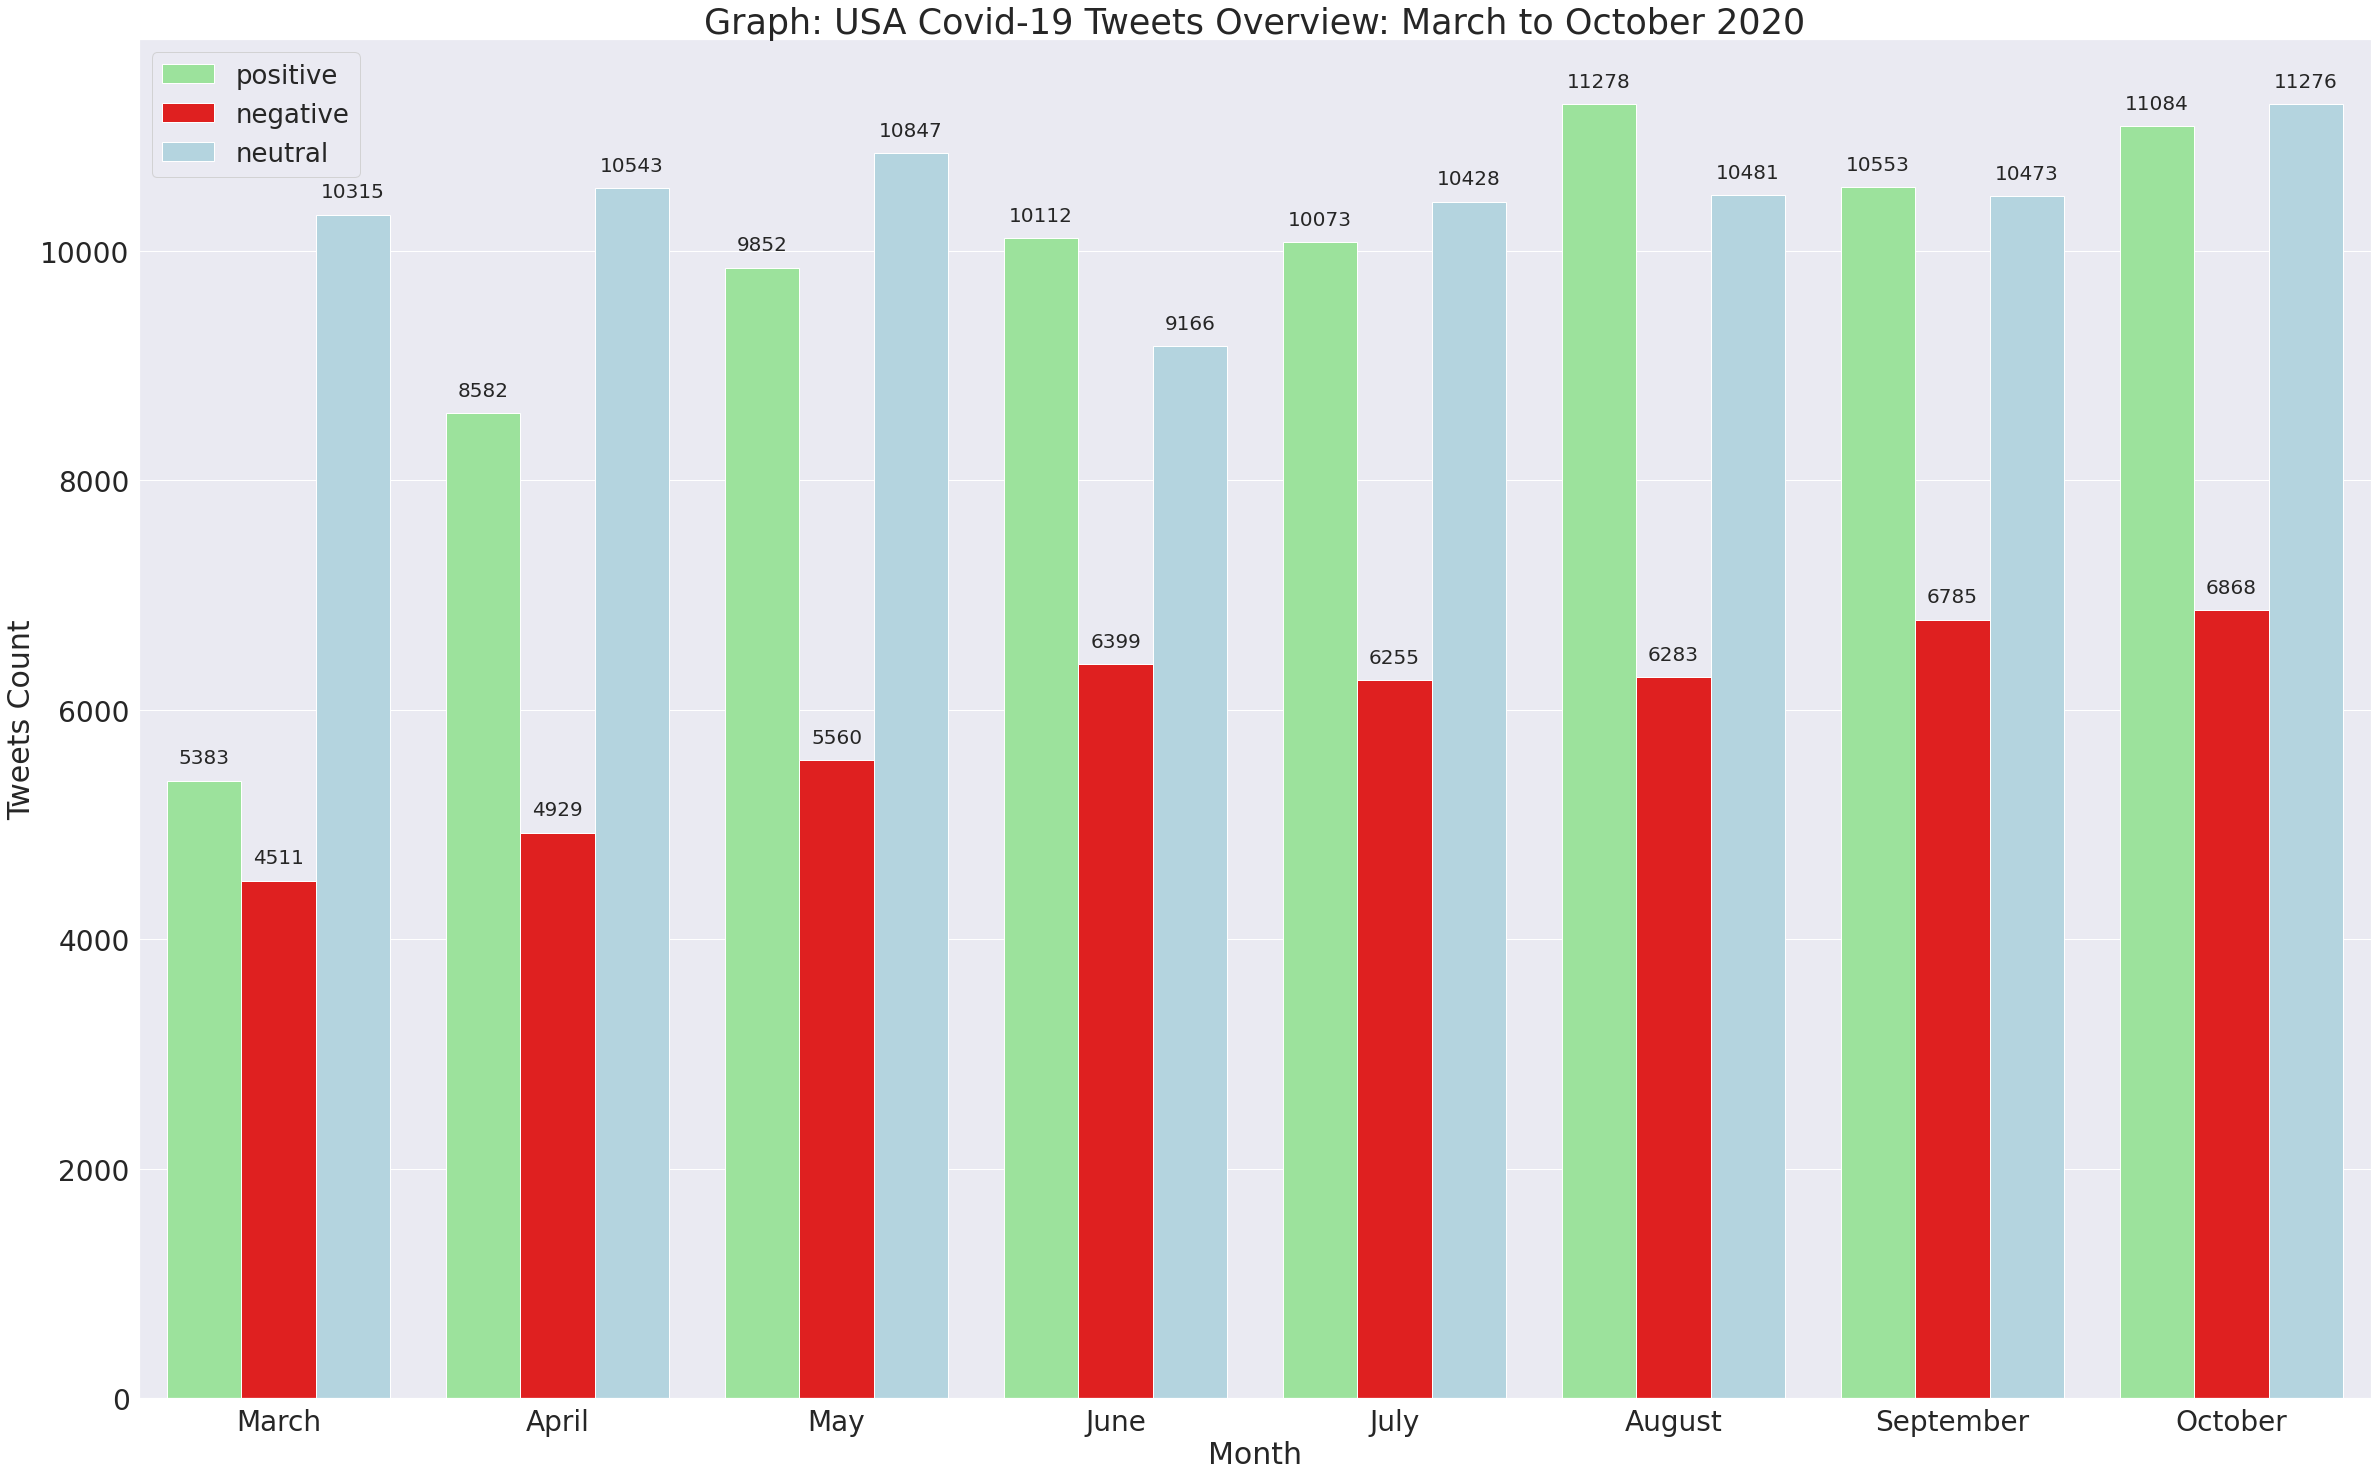

In [ ]:
#Plot each month's sentiment category for comparison purpose 

plt.figure(figsize=(40,25))
ax = sns.countplot(x='month',hue='textblob_label',data=usa_full,palette=['lightgreen','red','lightblue'])
total = float(len(usa_full))
for p in ax.patches:
        #percentage1= '{:.3f}%'.format(100 * p.get_height()/total)
        percentage = p.get_height()
        x = p.get_x() + p.get_width()/2 
        y = p.get_y() + p.get_height()+150
        ax.annotate(percentage, (x, y), ha="center", fontsize = 20)  
plt.xticks(fontsize =28)
plt.legend(loc='upper left', prop={'size': 26})
plt.yticks(fontsize =28)
plt.xticks(fontsize =28)
plt.xlabel('Month', fontsize=30)
plt.ylabel('Tweets Count', fontsize=30)
plt.title('Graph: USA Covid-19 Tweets Overview: March to October 2020', fontsize =35)

In [ ]:
# create new dataframe only contain negative and positive category
usa_negative =usa_full.loc[(usa_full['textblob_label']=='negative'),:] 
usa_positive =usa_full.loc[(usa_full['textblob_label']=='positive'),:] 
usa_negative_and_positive = pd.concat([usa_negative,usa_positive],ignore_index =True)

print(len(usa_negative))
print(len(usa_positive))
print(len(usa_negative_and_positive))

47590
76917
124507


Text(0.5, 1.0, 'Graph: USA Covid-19 Positive & Negative Tweets Overview: March to October 2020')

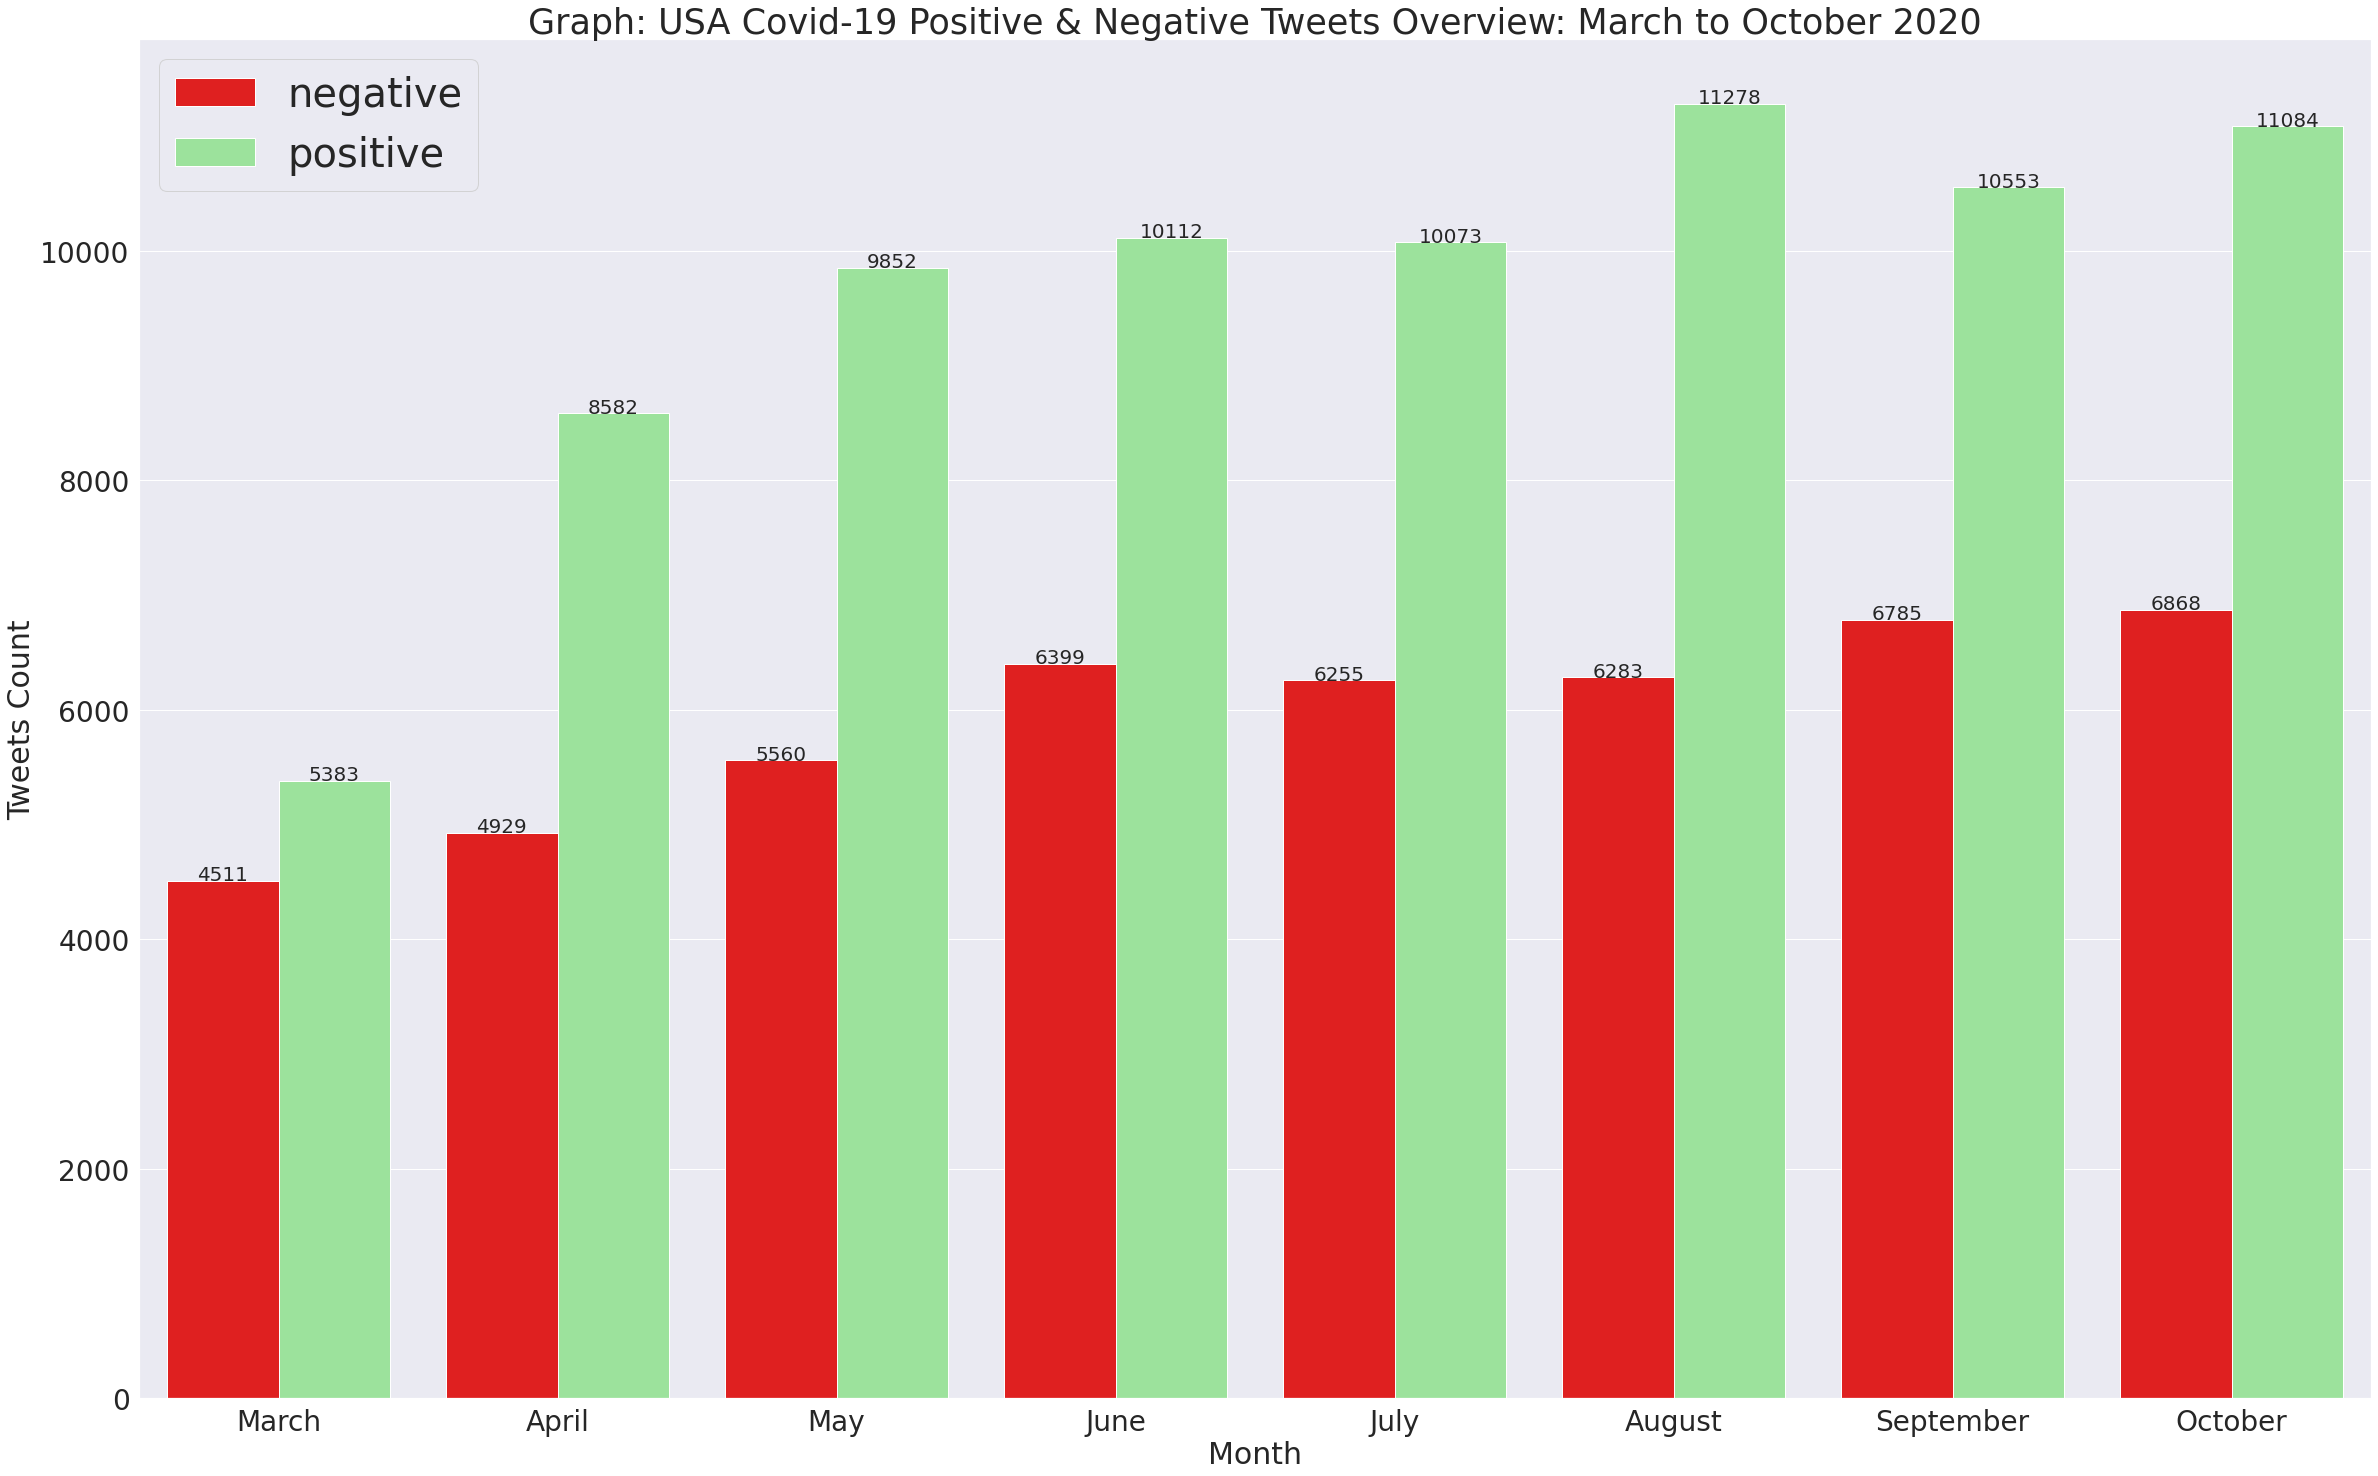

In [ ]:
## Only plot negative and positive categories to get more intuitive result

plt.figure(figsize=(40,25))
ax = sns.countplot(x='month',hue='textblob_label',data=usa_negative_and_positive, palette=['red', 'lightgreen'])
total = float(len(usa_negative_and_positive))
for p in ax.patches:
        #percentage1= '{:.3f}%'.format(100 * p.get_height()/total)
        percentage = p.get_height()
        x = p.get_x() + p.get_width()/2 
        y = p.get_y() + p.get_height()+5
        ax.annotate(percentage, (x, y), ha="center", fontsize = 20)  
plt.xticks(fontsize =28)
plt.legend(loc='upper left', prop={'size': 40})
plt.yticks(fontsize =28)
plt.xticks(fontsize =28)
plt.xlabel('Month', fontsize=30)
plt.ylabel('Tweets Count', fontsize=30)
plt.title('Graph: USA Covid-19 Positive & Negative Tweets Overview: March to October 2020', fontsize =35)

date  tweet  ...  location  month
month_number textblob_label                ...                 
03           negative         4511   4511  ...      4337   4511
             positive         5383   5383  ...      5217   5383
04           negative         4929   4929  ...      4824   4929
             positive         8582   8582  ...      8452   8582
05           negative         5560   5560  ...      5460   5560
             positive         9852   9852  ...      9696   9852
06           negative         6399   6399  ...      6311   6399
             positive        10112  10112  ...      9977  10112
07           negative         6255   6255  ...      6185   6255
             positive        10073  10073  ...      9973  10073
08           negative         6283   6283  ...      5591   6283
             positive        11278  11278  ...     10204  11278
09           negative         6785   6785  ...      5840   6785
             positive        10553  10553  ...      9266  10553
10           negative         6868   6868  ...      5926   6868
             positive        11084  11084  ...      9704  11084

[16 rows x 7 columns]

Text(0.5, 1.0, 'Graph: USA Covid-19 Positive & Negative Tweets Volumn Change Over Time')

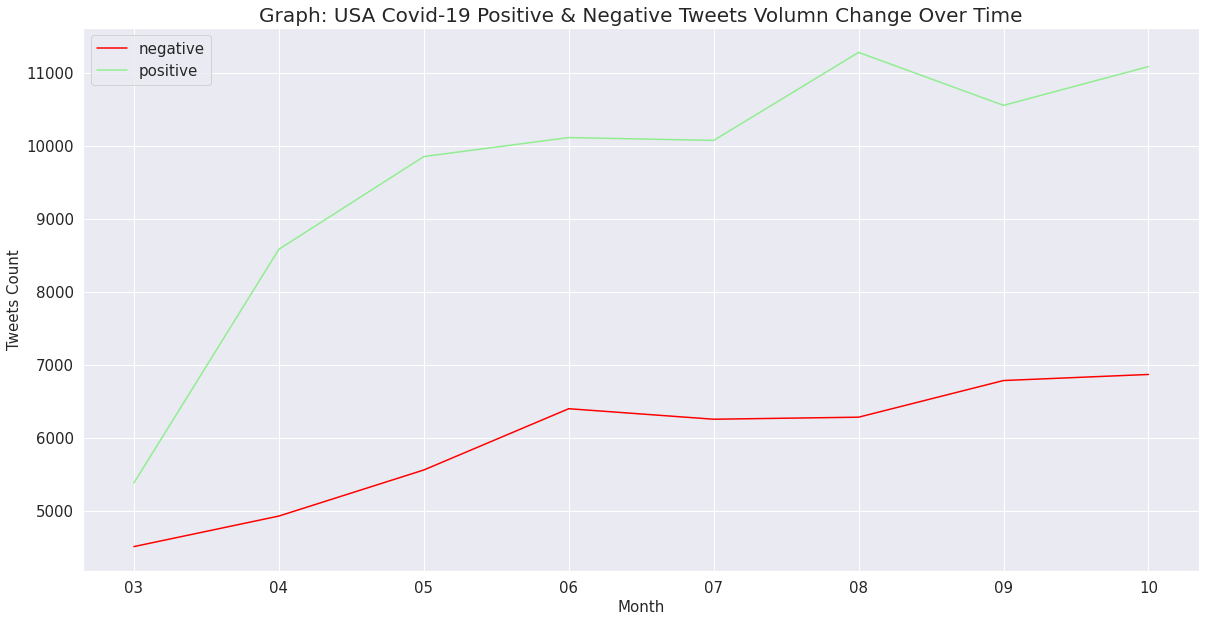

In [ ]:
#Create a pivot table for negative and positive category for each month
# and plot a line graph to understand the trend

a = usa_negative_and_positive.groupby(['month_number','textblob_label']).count()
display(a)
#sns.lineplot(data=canada_negative_and_positive, x="month_number", y="tweet", hue="label")
plt.figure(figsize=(20,10))

sns.lineplot(x="month_number", y="date", hue='textblob_label', data=a, palette=['red', 'lightgreen'])
plt.xticks(fontsize =28)
plt.legend(loc='upper left', prop={'size': 15})
plt.yticks(fontsize =15)
plt.xticks(fontsize =15)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Tweets Count', fontsize=15)
plt.title('Graph: USA Covid-19 Positive & Negative Tweets Volumn Change Over Time', fontsize =20)

# Print some sample Tweets

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)


print(usa_full['tweet'][5:100])


5     ' how ad the corona virus gonna e in the upcoming days?'                                                                                                                                                                                                  
6     'They cancelled my study aroad trip in the fall ecause of Corona...Ya girl aint going to France anymore ;wnIm really ummed out dnsnfs'                                                                                                                    
7     'RT : now I have these corona yoplets who need homes. RT this and follow these crimes and on ~**sunday night**~ I will commu'                                                                                                                             
8     'RT : As the new world Corona champs, I for one am tired of all the winning.'                                                                                                                                                  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


# Preprocess Tweets


In [ ]:
# test
df_test = usa_full.copy()
df_test["new_column"] = df_test['tweet'].str.replace('[^\w\s]','')
df_test["new_column"]  = df_test["new_column"].str.lower()
df_test

,date,tweet,vader_score,vader_label,textblob_score,textblob_label,location,month,month_number,new_column
0,Fri Mar 27 00:01:55 +0000 2020,'Corona aint really killing people until thanos snap his fingers',"[0.0, 0.707, 0.293, 0.5765]",neutral,0.200000,positive,Arizona,March,03,corona aint really killing people until thanos snap his fingers
1,Fri Mar 27 00:02:26 +0000 2020,"'rzte recyceln Schutzmasken, -Krise f\xchrt zum Sturm auf Spitler. Vergleiche drngen sich auf mit /11: Das Virus zerst\x6rt zwar keine Geude, doch die Angst ist jetzt fast gr\x6r als damals. - '","[0.112, 0.888, 0.0, -0.5994]",neutral,0.200000,positive,New York,March,03,rzte recyceln schutzmasken krise fxchrt zum sturm auf spitler vergleiche drngen sich auf mit 11 das virus zerstx6rt zwar keine geude doch die angst ist jetzt fast grx6r als damals
2,Fri Mar 27 00:03:43 +0000 2020,'Niggas cant read graphs or epi tales ut wanna tell u where they think corona came from im tired',"[0.238, 0.762, 0.0, -0.6486]",neutral,-0.400000,negative,"Durham, NC",March,03,niggas cant read graphs or epi tales ut wanna tell u where they think corona came from im tired
3,Fri Mar 27 00:04:19 +0000 2020,'RT : KCON NY just got cancelled. I stg if corona takes my NCT127 &amp; Monsta X concert too....... ',"[0.095, 0.905, 0.0, -0.25]",neutral,0.000000,neutral,"Denver, CO",March,03,rt kcon ny just got cancelled i stg if corona takes my nct127 amp monsta x concert too
4,Fri Mar 27 00:04:26 +0000 2020,"' Thats crazy, niggas out here charging for food during corona '","[0.324, 0.676, 0.0, -0.5859]",neutral,-0.600000,negative,"Boston, MA",March,03,thats crazy niggas out here charging for food during corona
...,...,...,...,...,...,...,...,...,...,...
208031,Sat Oct 31 23:21:38 +0000 2020,'Stanford study estimates Trump rallies resulted in over COVID-19 cases ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,"Illinois, USA",October,10,stanford study estimates trump rallies resulted in over covid19 cases
208032,Sat Oct 31 23:15:51 +0000 2020,"'Its no joke, yall. We are in quarantine and have een apart at a time when we really want to take care of one another. Thankfully, we are not terrily ill. Please, please continue to e vigilant and wear masks, wash your hands and stay socially distant. '","[0.067, 0.692, 0.241, 0.8432]",neutral,-0.133333,negative,"Jacksonville, FL",October,10,its no joke yall we are in quarantine and have een apart at a time when we really want to take care of one another thankfully we are not terrily ill please please continue to e vigilant and wear masks wash your hands and stay socially distant
208033,Sat Oct 31 23:47:36 +0000 2020,'Although and I are separated due to Im grateful for Scout and my ! We are fortunate ut when I think aout the millions of people who have suffered and died needlessly ecause of the lack of leadership in D.C. ',"[0.183, 0.702, 0.115, -0.5411]",neutral,-0.085417,negative,"Jacksonville, FL",October,10,although and i are separated due to im grateful for scout and my we are fortunate ut when i think aout the millions of people who have suffered and died needlessly ecause of the lack of leadership in dc
208034,Sat Oct 31 23:06:02 +0000 2020,'the est....super spreader? ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,West Shokan NY USA,October,10,the estsuper spreader


In [ ]:
# print sample tweets again after preprocessing
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)


print(df_test['new_column'][5:100])

5      how ad the corona virus gonna e in the upcoming days                                                                                                                                                                                           
6     they cancelled my study aroad trip in the fall ecause of coronaya girl aint going to france anymore wnim really ummed out dnsnfs                                                                                                                
7     rt  now i have these corona yoplets who need homes rt this and follow these crimes and on sunday night i will commu                                                                                                                             
8     rt  as the new world corona champs i for one am tired of all the winning                                                                                                                                                                        
9      no le

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


# decide to use this preprocessing helper function to process tweets

In [ ]:
# decide to use this preprocessing helper function to process tweets
import re

def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)

    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)

    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text

In [ ]:
preprocessed = [preprocess(message) for message in tqdm(df_test['new_column'])]


In [ ]:
# check processed tweets samples

preprocessed[0:20]

['corona aint really killing people until thanos snap his fingers',
 'rzte recyceln schutzmasken krise fxchrt zum sturm auf spitler vergleiche drngen sich auf mit das virus zerstx rt zwar keine geude doch die angst ist jetzt fast grx als damals',
 'niggas cant read graphs or epi tales ut wanna tell where they think corona came from im tired',
 'rt kcon ny just got cancelled stg if corona takes my nct amp monsta concert too',
 'thats crazy niggas out here charging for food during corona',
 'how ad the corona virus gonna in the upcoming days',
 'they cancelled my study aroad trip in the fall ecause of coronaya girl aint going to france anymore wnim really ummed out dnsnfs',
 'rt now have these corona yoplets who need homes rt this and follow these crimes and on sunday night will commu',
 'rt as the new world corona champs for one am tired of all the winning',
 'no let her go and return her items along with all of her friends corona virus will waiting for them',
 'rt watching todays coron

# Tokenize Tweets 
we use NLTK library with lemmatization and stopword removal. 

In [ ]:
#helper function
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def tokenize_text(text, option):
  '''
  Tokenize the input text as per specified option
    1: Use python split() function
    2: Use regex to extract alphabets plus 's and 't
    3: Use NLTK word_tokenize()
    4: Use NLTK word_tokenize(), remove stop words and apply lemmatization
  '''
  if option == 1:
    return text.split()
  elif option == 2:
    return re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
  elif option == 3:
    return [word for word in word_tokenize(text) if (word.isalpha()==1)]
  elif option == 4:
    words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return lemmatized
  else:
    logger.warn("Please specify option value between 1 and 4")
    return []

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# <font color='violet'>3. USA Most frequent terms Analysis</font> 
## Creat word cloud 
## Plot bar graph for top 80 most frequent terms 



[2020-11-13 01:29:51,258][INFO] ## The number of all words: 2377951
[2020-11-13 01:29:51,635][INFO] ## The number of unique words: 93234
[2020-11-13 01:29:51,673][INFO] ## Top 40 frequent words: ['covid', 'rt', 'corona', 'get', 'trump', 'people', 'virus', 'test', 'aout', 'coronavirus', 'case', 'say', 'go', 'death', 'amp', 'u', 'new', 'ut', 'like', 'die', 'one', 'know', 'state', 'dont', 'day', 'mask', 'een', 'make', 'take', 'think', 'time', 'im', 'need', 'positive', 'ecause', 'american', 'pandemic', 'see', 'work', 'report']


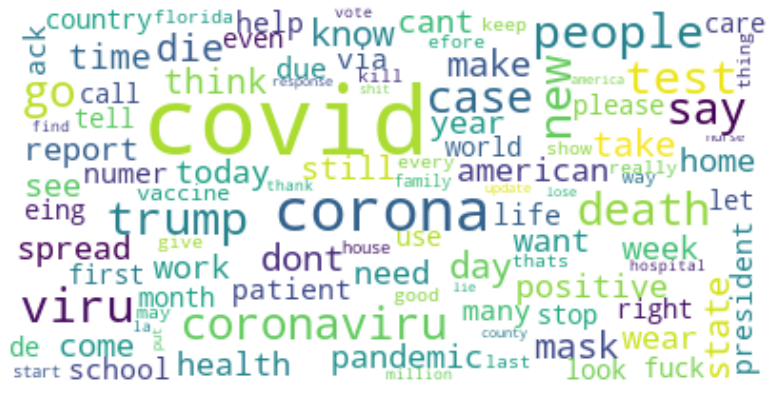

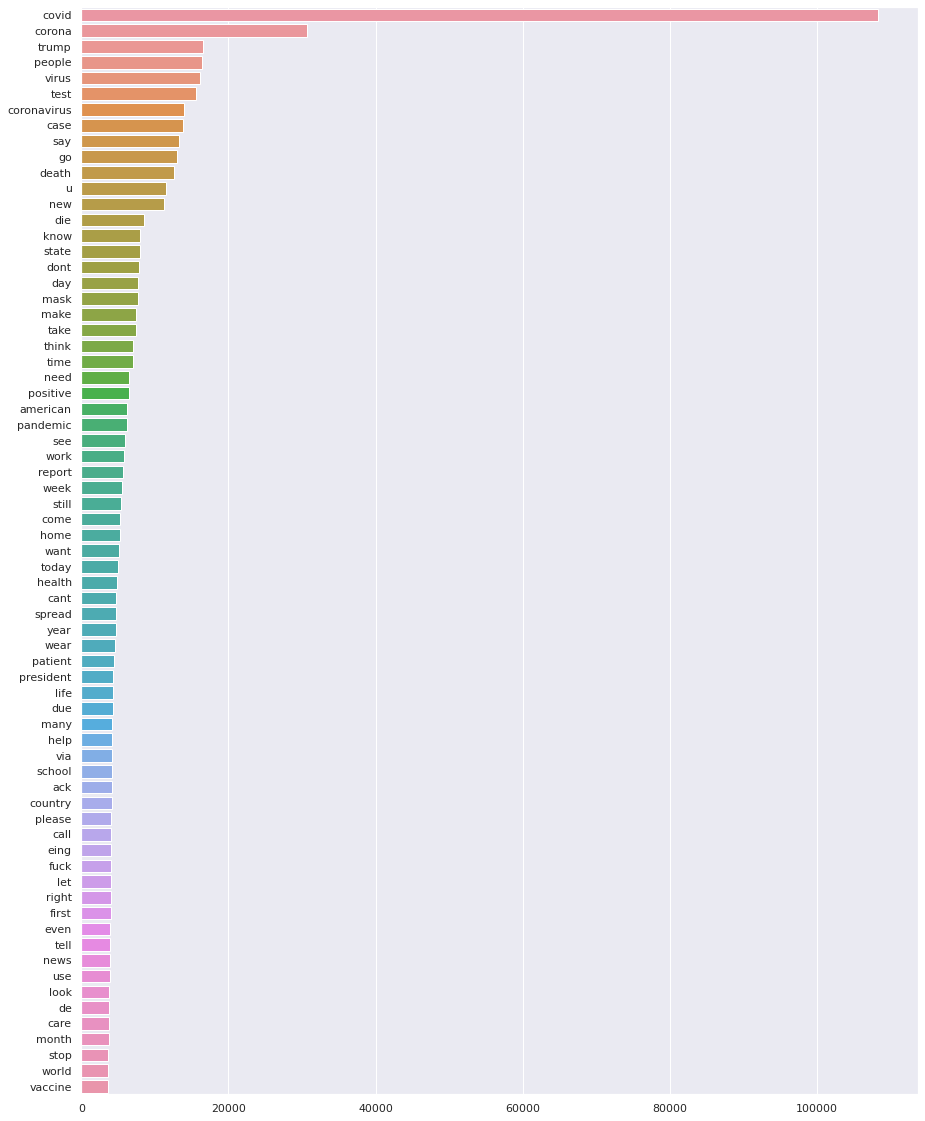

In [ ]:

# Create vocab
def create_vocab(messages, show_graph=False):
    corpus = []
    for message in tqdm(messages, desc="Tokenizaing"):
        tokens = tokenize_text(message, 4) # Use option 3
        corpus.extend(tokens)
    logger.info("The number of all words: {}".format(len(corpus)))

    # Create Counter
    counts = Counter(corpus)
    logger.info("The number of unique words: {}".format(len(counts)))

    # Create BoW
    bow = sorted(counts, key=counts.get, reverse=True)
    logger.info("Top 40 frequent words: {}".format(bow[:40]))

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    if show_graph:
        from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
        # Generate Word Cloud image
        text = " ".join(corpus)
        stopwords = set(STOPWORDS)
        stopwords.update(["I", "e", "the", "amp", "will", "y",'aout','ut','een','A','The','This','one','rt','ecause','im'])

        wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(15,7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

        # Show most frequent words in a bar graph
        most = counts.most_common()[:80]
        x, y = [], []
        for word, count in most:
            if word not in stopwords:
                x.append(word)
                y.append(count)
        plt.figure(figsize=(15,20))
        sns.barplot(x=y, y=x)
        plt.show()

    return vocab

vocab= create_vocab(preprocessed, True)

## Create token id list
#token_ids = [[vocab[word] for word in text_words] for text_words in tokenized] # comment out to save memory


# <font color='orange'>4. USA Random Baseline</font> 
Establish a random baseline: randomly assign label to each tweet.
From mathematic perspective, if our model can beat the random score basline, it means our model is making an impact. 

In [ ]:
usa_baseline = usa_full.copy()
usa_baseline

,date,tweet,vader_score,vader_label,textblob_score,textblob_label,location,month,month_number
0,Fri Mar 27 00:01:55 +0000 2020,'Corona aint really killing people until thanos snap his fingers',"[0.0, 0.707, 0.293, 0.5765]",neutral,0.200000,positive,Arizona,March,03
1,Fri Mar 27 00:02:26 +0000 2020,"'rzte recyceln Schutzmasken, -Krise f\xchrt zum Sturm auf Spitler. Vergleiche drngen sich auf mit /11: Das Virus zerst\x6rt zwar keine Geude, doch die Angst ist jetzt fast gr\x6r als damals. - '","[0.112, 0.888, 0.0, -0.5994]",neutral,0.200000,positive,New York,March,03
2,Fri Mar 27 00:03:43 +0000 2020,'Niggas cant read graphs or epi tales ut wanna tell u where they think corona came from im tired',"[0.238, 0.762, 0.0, -0.6486]",neutral,-0.400000,negative,"Durham, NC",March,03
3,Fri Mar 27 00:04:19 +0000 2020,'RT : KCON NY just got cancelled. I stg if corona takes my NCT127 &amp; Monsta X concert too....... ',"[0.095, 0.905, 0.0, -0.25]",neutral,0.000000,neutral,"Denver, CO",March,03
4,Fri Mar 27 00:04:26 +0000 2020,"' Thats crazy, niggas out here charging for food during corona '","[0.324, 0.676, 0.0, -0.5859]",neutral,-0.600000,negative,"Boston, MA",March,03
...,...,...,...,...,...,...,...,...,...
208031,Sat Oct 31 23:21:38 +0000 2020,'Stanford study estimates Trump rallies resulted in over COVID-19 cases ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,"Illinois, USA",October,10
208032,Sat Oct 31 23:15:51 +0000 2020,"'Its no joke, yall. We are in quarantine and have een apart at a time when we really want to take care of one another. Thankfully, we are not terrily ill. Please, please continue to e vigilant and wear masks, wash your hands and stay socially distant. '","[0.067, 0.692, 0.241, 0.8432]",neutral,-0.133333,negative,"Jacksonville, FL",October,10
208033,Sat Oct 31 23:47:36 +0000 2020,'Although and I are separated due to Im grateful for Scout and my ! We are fortunate ut when I think aout the millions of people who have suffered and died needlessly ecause of the lack of leadership in D.C. ',"[0.183, 0.702, 0.115, -0.5411]",neutral,-0.085417,negative,"Jacksonville, FL",October,10
208034,Sat Oct 31 23:06:02 +0000 2020,'the est....super spreader? ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,West Shokan NY USA,October,10


In [ ]:
# assign number to textblob_label, positive: 2, neutral: 1, negative: 0 for classification purpose
usa_baseline['number_textblob_label'] = usa_baseline['textblob_label'].replace(to_replace=["positive",'neutral','negative'],value=[2,1,0])
usa_baseline



,date,tweet,vader_score,vader_label,textblob_score,textblob_label,location,month,month_number,number_textblob_label
0,Fri Mar 27 00:01:55 +0000 2020,'Corona aint really killing people until thanos snap his fingers',"[0.0, 0.707, 0.293, 0.5765]",neutral,0.200000,positive,Arizona,March,03,2
1,Fri Mar 27 00:02:26 +0000 2020,"'rzte recyceln Schutzmasken, -Krise f\xchrt zum Sturm auf Spitler. Vergleiche drngen sich auf mit /11: Das Virus zerst\x6rt zwar keine Geude, doch die Angst ist jetzt fast gr\x6r als damals. - '","[0.112, 0.888, 0.0, -0.5994]",neutral,0.200000,positive,New York,March,03,2
2,Fri Mar 27 00:03:43 +0000 2020,'Niggas cant read graphs or epi tales ut wanna tell u where they think corona came from im tired',"[0.238, 0.762, 0.0, -0.6486]",neutral,-0.400000,negative,"Durham, NC",March,03,0
3,Fri Mar 27 00:04:19 +0000 2020,'RT : KCON NY just got cancelled. I stg if corona takes my NCT127 &amp; Monsta X concert too....... ',"[0.095, 0.905, 0.0, -0.25]",neutral,0.000000,neutral,"Denver, CO",March,03,1
4,Fri Mar 27 00:04:26 +0000 2020,"' Thats crazy, niggas out here charging for food during corona '","[0.324, 0.676, 0.0, -0.5859]",neutral,-0.600000,negative,"Boston, MA",March,03,0
...,...,...,...,...,...,...,...,...,...,...
208031,Sat Oct 31 23:21:38 +0000 2020,'Stanford study estimates Trump rallies resulted in over COVID-19 cases ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,"Illinois, USA",October,10,1
208032,Sat Oct 31 23:15:51 +0000 2020,"'Its no joke, yall. We are in quarantine and have een apart at a time when we really want to take care of one another. Thankfully, we are not terrily ill. Please, please continue to e vigilant and wear masks, wash your hands and stay socially distant. '","[0.067, 0.692, 0.241, 0.8432]",neutral,-0.133333,negative,"Jacksonville, FL",October,10,0
208033,Sat Oct 31 23:47:36 +0000 2020,'Although and I are separated due to Im grateful for Scout and my ! We are fortunate ut when I think aout the millions of people who have suffered and died needlessly ecause of the lack of leadership in D.C. ',"[0.183, 0.702, 0.115, -0.5411]",neutral,-0.085417,negative,"Jacksonville, FL",October,10,0
208034,Sat Oct 31 23:06:02 +0000 2020,'the est....super spreader? ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,West Shokan NY USA,October,10,1


In [ ]:
#create a random baseline, assign randomly to each tweet with score from int (0,1,2)
usa_baseline['random_score'] = np.random.randint(0, 3, len(usa_baseline))
usa_baseline


,date,tweet,vader_score,vader_label,textblob_score,textblob_label,location,month,month_number,number_textblob_label,random_score
0,Fri Mar 27 00:01:55 +0000 2020,'Corona aint really killing people until thanos snap his fingers',"[0.0, 0.707, 0.293, 0.5765]",neutral,0.200000,positive,Arizona,March,03,2,2
1,Fri Mar 27 00:02:26 +0000 2020,"'rzte recyceln Schutzmasken, -Krise f\xchrt zum Sturm auf Spitler. Vergleiche drngen sich auf mit /11: Das Virus zerst\x6rt zwar keine Geude, doch die Angst ist jetzt fast gr\x6r als damals. - '","[0.112, 0.888, 0.0, -0.5994]",neutral,0.200000,positive,New York,March,03,2,0
2,Fri Mar 27 00:03:43 +0000 2020,'Niggas cant read graphs or epi tales ut wanna tell u where they think corona came from im tired',"[0.238, 0.762, 0.0, -0.6486]",neutral,-0.400000,negative,"Durham, NC",March,03,0,0
3,Fri Mar 27 00:04:19 +0000 2020,'RT : KCON NY just got cancelled. I stg if corona takes my NCT127 &amp; Monsta X concert too....... ',"[0.095, 0.905, 0.0, -0.25]",neutral,0.000000,neutral,"Denver, CO",March,03,1,2
4,Fri Mar 27 00:04:26 +0000 2020,"' Thats crazy, niggas out here charging for food during corona '","[0.324, 0.676, 0.0, -0.5859]",neutral,-0.600000,negative,"Boston, MA",March,03,0,2
...,...,...,...,...,...,...,...,...,...,...,...
208031,Sat Oct 31 23:21:38 +0000 2020,'Stanford study estimates Trump rallies resulted in over COVID-19 cases ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,"Illinois, USA",October,10,1,0
208032,Sat Oct 31 23:15:51 +0000 2020,"'Its no joke, yall. We are in quarantine and have een apart at a time when we really want to take care of one another. Thankfully, we are not terrily ill. Please, please continue to e vigilant and wear masks, wash your hands and stay socially distant. '","[0.067, 0.692, 0.241, 0.8432]",neutral,-0.133333,negative,"Jacksonville, FL",October,10,0,2
208033,Sat Oct 31 23:47:36 +0000 2020,'Although and I are separated due to Im grateful for Scout and my ! We are fortunate ut when I think aout the millions of people who have suffered and died needlessly ecause of the lack of leadership in D.C. ',"[0.183, 0.702, 0.115, -0.5411]",neutral,-0.085417,negative,"Jacksonville, FL",October,10,0,2
208034,Sat Oct 31 23:06:02 +0000 2020,'the est....super spreader? ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,West Shokan NY USA,October,10,1,2


In [ ]:
print(usa_baseline['random_score'].nunique())

3


USA Random Baseline Classifier report 
               precision    recall  f1-score   support

           0       0.23      0.33      0.27     47590
           1       0.40      0.33      0.36     83529
           2       0.37      0.33      0.35     76917

    accuracy                           0.33    208036
   macro avg       0.33      0.33      0.33    208036
weighted avg       0.35      0.33      0.34    208036



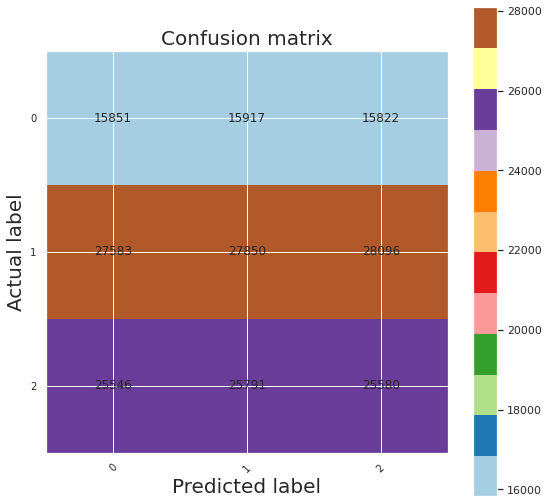

In [ ]:
# random baseline confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


print("USA Random Baseline Classifier report \n", classification_report(usa_baseline['number_textblob_label'], usa_baseline['random_score']))

# confusion matrix
plt.figure(figsize=(9,9))

dree_cm=confusion_matrix(usa_baseline['number_textblob_label'], usa_baseline['random_score'])

#cmap name: terrain, ocean,Accent,Paired
plt.imshow(dree_cm, interpolation='nearest', cmap='Paired')
plt.title('Confusion matrix', size = 20)
plt.colorbar()
# tick_marks = np.arange(3)
plt.xticks(tick_marks, rotation=45, size = 10)
plt.yticks(tick_marks,  size = 10)
# plt.tight_layout()
plt.ylabel('Actual label', size = 20)
plt.xlabel('Predicted label', size = 20)
width, height = dree_cm.shape
for x in range(width):
     for y in range(height):
              plt.annotate(str(dree_cm[x][y]), xy=(y, x), 
              horizontalalignment='center',
              verticalalignment='center')

# <font color='blue'>5. USA Bert Model classification</font> 

# Process Data for Bert Model
## assign label with different number: 
positive 2
neutral 1
negative 0

In [ ]:
df_test['number_textblob_label'] = df_test['textblob_label'].replace(to_replace=["positive",'neutral','negative'],value=[2,1,0])
df_test

,date,tweet,vader_score,vader_label,textblob_score,textblob_label,location,month,month_number,new_column,number_textblob_label
0,Fri Mar 27 00:01:55 +0000 2020,'Corona aint really killing people until thanos snap his fingers',"[0.0, 0.707, 0.293, 0.5765]",neutral,0.200000,positive,Arizona,March,03,corona aint really killing people until thanos snap his fingers,2
1,Fri Mar 27 00:02:26 +0000 2020,"'rzte recyceln Schutzmasken, -Krise f\xchrt zum Sturm auf Spitler. Vergleiche drngen sich auf mit /11: Das Virus zerst\x6rt zwar keine Geude, doch die Angst ist jetzt fast gr\x6r als damals. - '","[0.112, 0.888, 0.0, -0.5994]",neutral,0.200000,positive,New York,March,03,rzte recyceln schutzmasken krise fxchrt zum sturm auf spitler vergleiche drngen sich auf mit 11 das virus zerstx6rt zwar keine geude doch die angst ist jetzt fast grx6r als damals,2
2,Fri Mar 27 00:03:43 +0000 2020,'Niggas cant read graphs or epi tales ut wanna tell u where they think corona came from im tired',"[0.238, 0.762, 0.0, -0.6486]",neutral,-0.400000,negative,"Durham, NC",March,03,niggas cant read graphs or epi tales ut wanna tell u where they think corona came from im tired,0
3,Fri Mar 27 00:04:19 +0000 2020,'RT : KCON NY just got cancelled. I stg if corona takes my NCT127 &amp; Monsta X concert too....... ',"[0.095, 0.905, 0.0, -0.25]",neutral,0.000000,neutral,"Denver, CO",March,03,rt kcon ny just got cancelled i stg if corona takes my nct127 amp monsta x concert too,1
4,Fri Mar 27 00:04:26 +0000 2020,"' Thats crazy, niggas out here charging for food during corona '","[0.324, 0.676, 0.0, -0.5859]",neutral,-0.600000,negative,"Boston, MA",March,03,thats crazy niggas out here charging for food during corona,0
...,...,...,...,...,...,...,...,...,...,...,...
208031,Sat Oct 31 23:21:38 +0000 2020,'Stanford study estimates Trump rallies resulted in over COVID-19 cases ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,"Illinois, USA",October,10,stanford study estimates trump rallies resulted in over covid19 cases,1
208032,Sat Oct 31 23:15:51 +0000 2020,"'Its no joke, yall. We are in quarantine and have een apart at a time when we really want to take care of one another. Thankfully, we are not terrily ill. Please, please continue to e vigilant and wear masks, wash your hands and stay socially distant. '","[0.067, 0.692, 0.241, 0.8432]",neutral,-0.133333,negative,"Jacksonville, FL",October,10,its no joke yall we are in quarantine and have een apart at a time when we really want to take care of one another thankfully we are not terrily ill please please continue to e vigilant and wear masks wash your hands and stay socially distant,0
208033,Sat Oct 31 23:47:36 +0000 2020,'Although and I are separated due to Im grateful for Scout and my ! We are fortunate ut when I think aout the millions of people who have suffered and died needlessly ecause of the lack of leadership in D.C. ',"[0.183, 0.702, 0.115, -0.5411]",neutral,-0.085417,negative,"Jacksonville, FL",October,10,although and i are separated due to im grateful for scout and my we are fortunate ut when i think aout the millions of people who have suffered and died needlessly ecause of the lack of leadership in dc,0
208034,Sat Oct 31 23:06:02 +0000 2020,'the est....super spreader? ',"[0.0, 1.0, 0.0, 0.0]",neutral,0.000000,neutral,West Shokan NY USA,October,10,the estsuper spreader,1


In [ ]:
# compare results
sentiments = df_test['number_textblob_label']
messages = df_test['new_column']
tmp_dict = {'org message': messages, 'sentence': preprocessed, 'label': sentiments}
tmp_df = pd.DataFrame(tmp_dict).sample(n=20, random_state=rand_seed)

# Samples
pd.set_option('display.max_colwidth', 200)
tmp_df

,org message,sentence,label
19811,rt corona leshay davirus get yo ass in this mf house and leave them people alone,rt corona leshay davirus get yo ass in this mf house and leave them people alone,1
104853,rt more packages arrive from my special admirerthank you bgbtd for care in this corona virus shutdown x8,rt more packages arrive from my special admirerthank you bgbtd for care in this corona virus shutdown,2
94581,rt when covid came w warning the us didnt have enough masks ppe or tests when the peaceful protests came they were ready w,rt when covid came warning the us didnt have enough masks ppe or tests when the peaceful protests came they were ready,2
97097,rt x7we the people need to take a stand in of us have tested for covidx9wear masksx9keep apartx9amp keep our childre,rt we the people need to take stand in of us have tested for covidx wear masksx keep apartx amp keep our childre,1
88659,rt new york and new jersey got pummeled y covid19 ecause we didnt know enough fast enoughred states are getting pum,rt new york and new jersey got pummeled covid ecause we didnt know enough fast enoughred states are getting pum,2
104399,rt i just moved to miami amp have to get a covid testquarantine for weeks efore school which is fine i was asking where th,rt just moved to miami amp have to get covid testquarantine for weeks efore school which is fine was asking where th,2
148170,pelosi says white house proposal for 13 trillion in coronavirus relief would not meet the needs of american workers and families statement,pelosi says white house proposal for trillion in coronavirus relief would not meet the needs of american workers and families statement,1
68636,rt the demrats have played your silly games now its time to move on america is over covid19 im thinking the decea,rt the demrats have played your silly games now its time to move on america is over covid im thinking the decea,0
95806,rt reporters please stop asking the proudly maskless if theyre afraid of getting covid and start asking them why they ha,rt reporters please stop asking the proudly maskless if theyre afraid of getting covid and start asking them why they ha,2
112226,rt must watch it started with covid19 full government control then the riots in the streets whos ehind the,rt must watch it started with covid full government control then the riots in the streets whos ehind the,2


# USA Training data stats overview


[2020-11-13 01:31:51,318][INFO] ## The total number of input data: 182150


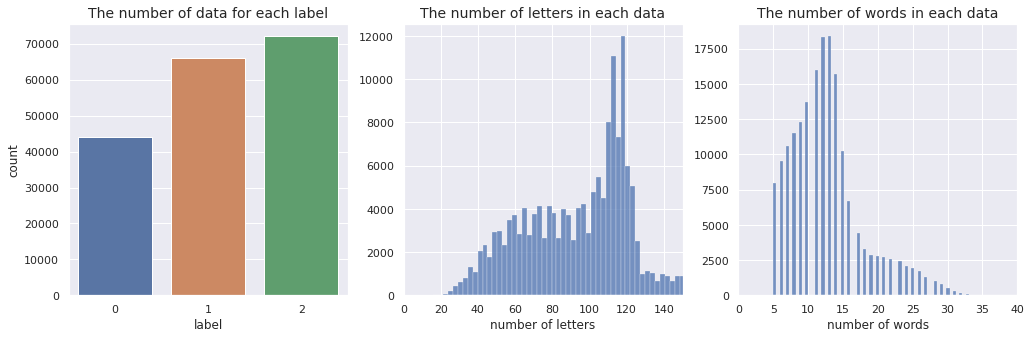

In [ ]:
# Create a dataframe for training data
word_cnt = [len(tokenize_text(x, 4)) for x in tqdm(preprocessed)]
messages = df_test['new_column']
sentiments = df_test['number_textblob_label']

# Use tweets having 5 or more words. Do not resample for balancing data here.
train_dict = {'text': preprocessed, 'label': sentiments, 'count': word_cnt}
train_df = pd.DataFrame(train_dict)
train_df = train_df.loc[train_df['count'] >= 5]
train_df.reset_index(drop=True, inplace=True)
logger.info("The total number of input data: {}".format(len(train_df)))

# Display the distribution graph
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(17,5))
sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('The number of data for each label', fontsize=14)
sns.histplot([len(x) for x in train_df['text']], ax=ax2, bins=100)
ax2.set_title('The number of letters in each data', fontsize=14)
ax2.set_xlim(0,150)
ax2.set_xlabel('number of letters')
ax2.set_ylabel("")
sns.histplot(train_df['count'], ax=ax3, bins=100)
ax3.set_title('The number of words in each data', fontsize=14)
ax3.set_xlim(0,40)
ax3.set_xlabel('number of words')
ax3.set_ylabel("")

plt.show()

# BERT Model Training

In [ ]:
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, TensorDataset, Dataset

from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup

# Pytorch Dataset
helper function: create a dataset class and data loader for pytroch

In [ ]:
# Define a DataSet Class which simply return (x, y) pair
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return self.datalist[idx]
  

# Data Loader
def create_data_loader(X, y, indices, batch_size, shuffle):
    X_sampled = np.array(X, dtype=object)[indices]
    y_sampled = np.array(y)[indices].astype(int)
    dataset = SimpleDataset(X_sampled, y_sampled)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

# Training code
The code is a combination of transformer and existing BERT implementation from GitHub

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_cycles(X_all, y_all, vocab, num_samples, model_type, epochs, patience, batch_size, seq_len, lr, clip, log_level):
    result = pd.DataFrame(columns=['Accuracy', 'F1(macro)', 'Total_Time', 'ms/text'], index=num_samples)

    for n in num_samples:
        print("")
        logger.info("############### Start training for %d samples ###############" %n)

        # Stratified sampling
        train_size = n / len(y_all)
        sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, test_size=train_size*0.2 , random_state=rand_seed)
        train_indices, valid_indices = next(sss.split(X_all, y_all))

        # Sample input data
        train_loader = create_data_loader(X_all, y_all, train_indices, batch_size, True)
        valid_loader = create_data_loader(X_all, y_all, valid_indices, batch_size, False)

        if model_type == 'LSTM':
            model = TextClassifier(len(vocab)+1, embed_size=512, lstm_size=1289, dense_size=0, output_size=5, lstm_layers=4, dropout=0.2)
            model.embedding.weight.data.uniform_(-1, 1)
        elif model_type == 'BERT':
            model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

        start_time = time.perf_counter() # use time.process_time() for CPU time
        acc, f1, model_trained = train_nn_model(model, model_type, train_loader, valid_loader, vocab, epochs, patience, batch_size, seq_len, lr, clip, log_level)
        end_time = time.perf_counter() # use time.process_time() for CPU time
        duration = end_time - start_time
        logger.info("Process Time (sec): {}".format(duration))
        result.loc[n] = (round(acc,4), round(f1,4), duration, duration/n*1000)

    return result, model_trained

In [ ]:
def train_nn_model(model, model_type, train_loader, valid_loader, vocab, epochs, patience, batch_size, seq_len, lr, clip, log_level):
    # Set variables
    logger = set_logger('sa_tweet_inperf', log_level)
    num_total_opt_steps = int(len(train_loader) * epochs)
    eval_every = len(train_loader) // 5
    warm_up_proportion = 0.1
    logger.info('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), epochs))

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = AdamW_HF(model.parameters(), lr=lr, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler
    criterion = nn.NLLLoss()

    # Set Train Mode
    model.train()

    # Initialise
    acc_train, f1_train, loss_train, acc_valid, f1_valid, loss_valid = [], [], [], [], [], []
    best_f1, early_stop, steps = 0, 0, 0
    class_names = ['0:Negative','1:Neutral', '2:Positive']

    for epoch in tqdm(range(epochs), desc="Epoch"):
        logger.info('================     epoch {}     ==============='.format(epoch+1))

        #################### Training ####################
        # Initialise
        loss_tmp, loss_cnt = 0, 0
        y_pred_tmp, y_truth_tmp = [], []
        hidden = model.init_hidden(batch_size) if model_type == "LSTM" else None

        for i, batch in enumerate(train_loader):
            text_batch, labels = batch
            # Skip the last batch of which size is not equal to batch_size
            if labels.size(0) != batch_size:
                break
            steps += 1
           
            # Reset gradient
            model.zero_grad()
            optimizer.zero_grad()

            # Initialise after the previous training
            if steps % eval_every == 1:
                y_pred_tmp, y_truth_tmp = [], []

            if model_type == "LSTM":
                # Tokenize the input and move to device
                text_batch = tokenizer_lstm(text_batch, vocab, seq_len, padding='left').transpose(1,0).to(device)
                labels = torch.tensor(labels, dtype=torch.int64).to(device)

                # Creating new variables for the hidden state to avoid backprop entire training history
                hidden = tuple([each.data for each in hidden])
                for each in hidden:
                    each.to(device)

                # Get output and hidden state from the model, calculate the loss
                logits, hidden = model(text_batch, hidden)
                loss = criterion(logits, labels)
                
            elif model_type == 'BERT':
                # Tokenize the input and move to device
                # Tokenizer Parameter
                param_tk = {
                    'return_tensors': "pt",
                    'padding': 'max_length',
                    'max_length': seq_len,
                    'add_special_tokens': True,
                    'truncation': True
                }
                text_batch = tokenizer_bert(text_batch, **param_tk).to(device)
                labels = torch.tensor(labels, dtype=torch.int64).to(device)

                # Feedforward prediction
                loss, logits = model(**text_batch, labels=labels)

            y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
            y_truth_tmp.extend(labels.cpu().numpy())

            # Back prop
            loss.backward()

            # Training Loss
            loss_tmp += loss.item()
            loss_cnt += 1

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()


            #################### Evaluation ####################
            if (steps % eval_every == 0) or ((steps % eval_every != 0) and (steps == len(train_loader))):
                # Evaluate Training
                acc, f1 = metric(y_truth_tmp, y_pred_tmp)
                acc_train.append(acc)
                f1_train.append(f1)
                loss_train.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # y_pred_tmp = np.zeros((len(y_valid), 5))
                y_truth_tmp, y_pred_tmp = [], []

                # Move to Evaluation Mode
                model.eval()

                with torch.no_grad():
                    for i, batch in enumerate(valid_loader):
                        text_batch, labels = batch
                        # Skip the last batch of which size is not equal to batch_size
                        if labels.size(0) != batch_size:
                            break

                        if model_type == "LSTM":
                            # Tokenize the input and move to device
                            text_batch = tokenizer_lstm(text_batch, vocab, seq_len, padding='left').transpose(1,0).to(device)
                            labels = torch.tensor(labels, dtype=torch.int64).to(device)

                            # Creating new variables for the hidden state to avoid backprop entire training history
                            hidden = tuple([each.data for each in hidden])
                            for each in hidden:
                                each.to(device)

                            # Get output and hidden state from the model, calculate the loss
                            logits, hidden = model(text_batch, hidden)
                            loss = criterion(logits, labels)
                
                        elif model_type == 'BERT':
                            # Tokenize the input and move to device
                            text_batch = tokenizer_bert(text_batch, **param_tk).to(device)
                            labels = torch.tensor(labels, dtype=torch.int64).to(device)
                            # Feedforward prediction
                            loss, logits = model(**text_batch, labels=labels)
                    
                        loss_tmp += loss.item()
                        loss_cnt += 1

                        y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
                        y_truth_tmp.extend(labels.cpu().numpy())
                        # logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))

                acc, f1 = metric(y_truth_tmp, y_pred_tmp)
                logger.debug("Epoch: {}/{}, Step: {}, Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f}".format(epoch+1, epochs, steps, loss_tmp, acc, f1))
                acc_valid.append(acc)
                f1_valid.append(f1)
                loss_valid.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # Back to train mode
                model.train()

        #################### End of each epoch ####################

        # Show the last evaluation metrics
        logger.info('Epoch: %d, Loss: %.4f, Acc: %.4f, F1: %.4f, LR: %.2e' % (epoch+1, loss_valid[-1], acc_valid[-1], f1_valid[-1], scheduler.get_last_lr()[0]))

        # Plot Confusion Matrix
        y_truth_class = [class_names[int(idx)] for idx in y_truth_tmp]
        y_predicted_class = [class_names[int(idx)] for idx in y_pred_tmp]
        
        titles_options = [("Actual Count", None), ("Normalised", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title, x_tick_rotation=75)
        plt.show()

        # plot training performance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
        ax1.set_title("Losses")
        ax1.set_xlabel("Validation Cycle")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_train, 'b-o', label='Train Loss')
        ax1.plot(loss_valid, 'r-o', label='Valid Loss')
        ax1.legend(loc="upper right")
        
        ax2.set_title("Evaluation")
        ax2.set_xlabel("Validation Cycle")
        ax2.set_ylabel("Score")
        ax2.set_ylim(0,1)
        ax2.plot(acc_train, 'y-o', label='Accuracy (train)')
        ax2.plot(f1_train, 'y--', label='F1 Score (train)')
        ax2.plot(acc_valid, 'g-o', label='Accuracy (valid)')
        ax2.plot(f1_valid, 'g--', label='F1 Score (valid)')
        ax2.legend(loc="upper left")

        plt.show()

        # If improving, save the number. If not, count up for early stopping
        if best_f1 < f1_valid[-1]:
            early_stop = 0
            best_f1 = f1_valid[-1]
        else:
            early_stop += 1

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Prepare for the next epoch
        if device == 'cuda:0':
            torch.cuda.empty_cache()
        model.train()

    return acc, f1, model


# Bert Model parameters


In [ ]:
# Set some training parameters and tested the model with different number of training samples
# Define the training parameters
num_samples = [1000, 5000, 10000, 50000]
epochs=5
patience=3
batch_size=64
seq_len = 30
lr=3e-4
clip=5
log_level=logging.DEBUG

In [ ]:
# Use pretrained BERT model from Hugging Face
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Tokenizer Parameter
param_tk = {
    'return_tensors': "pt",
    'padding': 'max_length',
    'max_length': seq_len,
    'add_special_tokens': True,
    'truncation': True
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# Define evaluation metrics
Accuracy and 
F1_score

In [ ]:
# Define metrics
from sklearn.metrics import accuracy_score, f1_score
import scikitplot as skplt

# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

# Train the BERT model


[2020-11-13 00:09:45,099][INFO] ## ############### Start training for 1000 samples ###############


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-11-13 00:09:49,585][INFO] ## Total Training Steps: 48 (16 batches x 3 epochs)


[2020-11-13 00:10:04,207][INFO] ## ================     epoch 1     ===============


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-11-13 00:10:05,151][DEBUG] ## Epoch: 1/3, Step: 3, Loss: 4.4743, Acc: 0.4010, F1: 0.1908


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-11-13 00:10:05,861][DEBUG] ## Epoch: 1/3, Step: 6, Loss: 3.6732, Acc: 0.4062, F1: 0.1926
[2020-11-13 00:10:06,557][DEBUG] ## Epoch: 1/3, Step: 9, Loss: 3.4335, Acc: 0.3490, F1: 0.1725
[2020-11-13 00:10:07,275][DEBUG] ## Epoch: 1/3, Step: 12, Loss: 3.3013, Acc: 0.4115, F1: 0.2262
[2020-11-13 00:10:07,981][DEBUG] ## Epoch: 1/3, Step: 15, Loss: 3.2724, Acc: 0.4115, F1: 0.2190
[2020-11-13 00:10:07,983][INFO] ## Epoch: 1, Loss: 1.0908, Acc: 0.4115, F1: 0.2190, LR: 1.53e-05


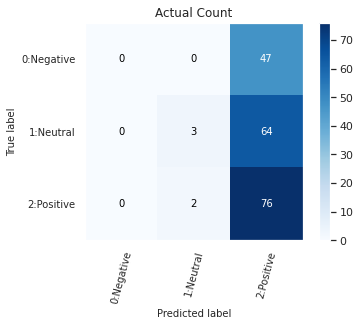

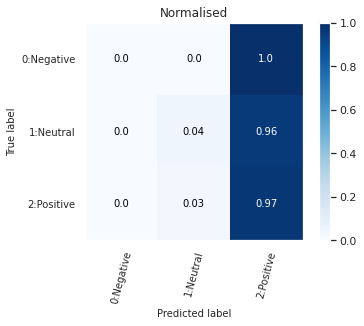

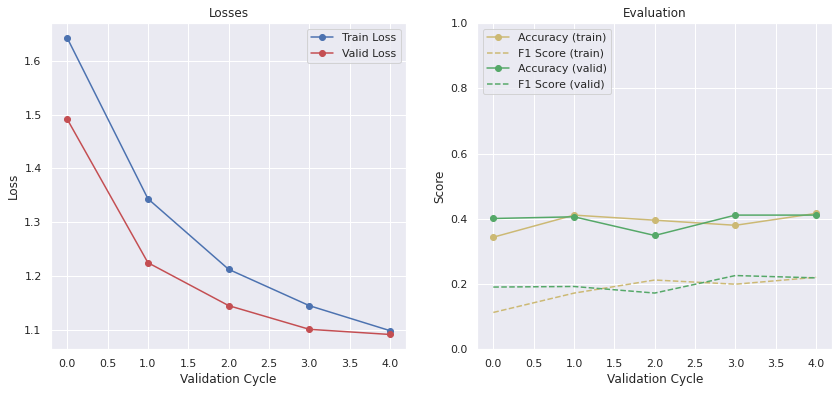

[2020-11-13 00:10:08,826][INFO] ## ================     epoch 2     ===============
[2020-11-13 00:10:09,199][DEBUG] ## Epoch: 2/3, Step: 16, Loss: 3.2655, Acc: 0.4115, F1: 0.2190
[2020-11-13 00:10:09,755][DEBUG] ## Epoch: 2/3, Step: 18, Loss: 3.2720, Acc: 0.4323, F1: 0.3132
[2020-11-13 00:10:10,473][DEBUG] ## Epoch: 2/3, Step: 21, Loss: 3.1997, Acc: 0.4271, F1: 0.3106
[2020-11-13 00:10:11,187][DEBUG] ## Epoch: 2/3, Step: 24, Loss: 3.1583, Acc: 0.4479, F1: 0.3015
[2020-11-13 00:10:11,922][DEBUG] ## Epoch: 2/3, Step: 27, Loss: 3.0553, Acc: 0.5156, F1: 0.3888
[2020-11-13 00:10:12,636][DEBUG] ## Epoch: 2/3, Step: 30, Loss: 3.0326, Acc: 0.5000, F1: 0.3790
[2020-11-13 00:10:12,638][INFO] ## Epoch: 2, Loss: 1.0109, Acc: 0.5000, F1: 0.3790, LR: 8.33e-06


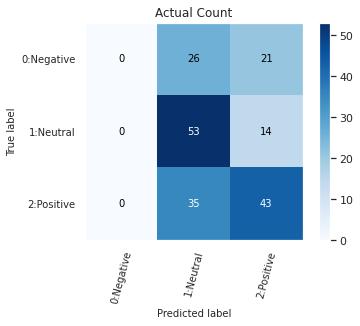

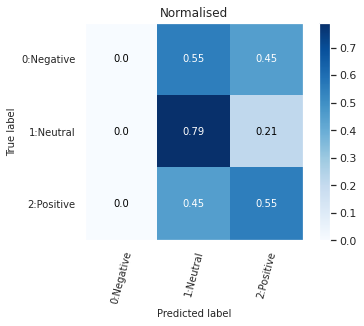

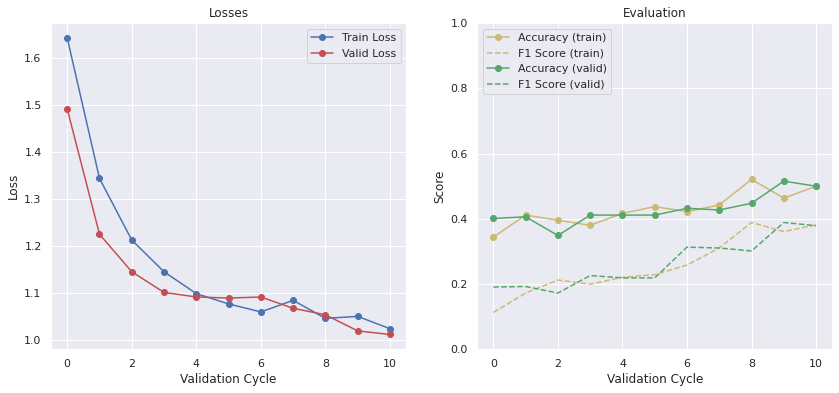

[2020-11-13 00:10:13,484][INFO] ## ================     epoch 3     ===============
[2020-11-13 00:10:14,202][DEBUG] ## Epoch: 3/3, Step: 33, Loss: 2.9800, Acc: 0.5312, F1: 0.4000
[2020-11-13 00:10:14,962][DEBUG] ## Epoch: 3/3, Step: 36, Loss: 2.9323, Acc: 0.5312, F1: 0.4024
[2020-11-13 00:10:15,677][DEBUG] ## Epoch: 3/3, Step: 39, Loss: 2.9309, Acc: 0.5417, F1: 0.4712
[2020-11-13 00:10:16,405][DEBUG] ## Epoch: 3/3, Step: 42, Loss: 2.9395, Acc: 0.5521, F1: 0.4988
[2020-11-13 00:10:17,123][DEBUG] ## Epoch: 3/3, Step: 45, Loss: 2.8934, Acc: 0.5417, F1: 0.4825
[2020-11-13 00:10:17,125][INFO] ## Epoch: 3, Loss: 0.9645, Acc: 0.5417, F1: 0.4825, LR: 1.39e-06


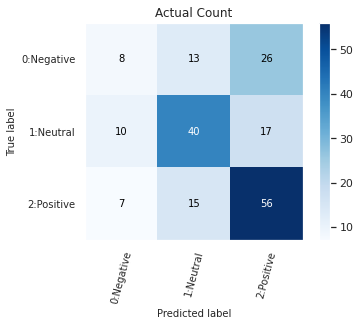

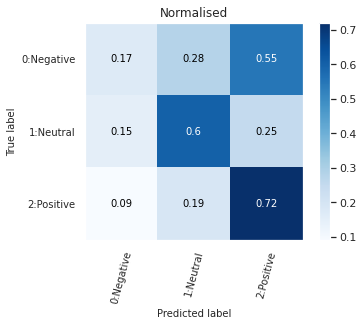

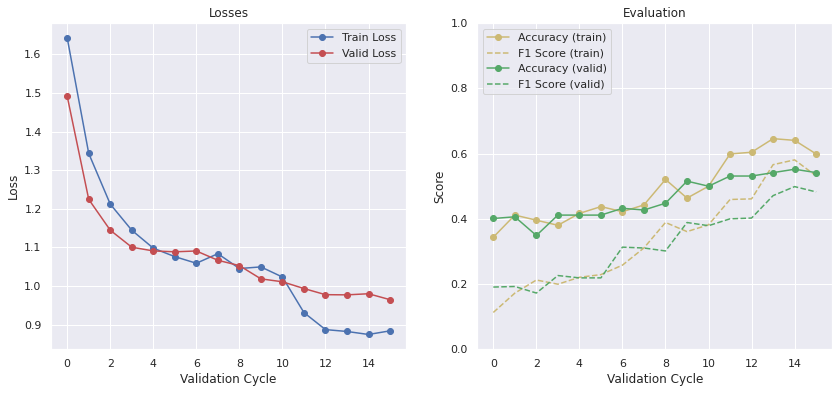


[2020-11-13 00:10:17,974][INFO] ## Process Time (sec): 28.388755003999904

[2020-11-13 00:10:17,977][INFO] ## ############### Start training for 5000 samples ###############


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-11-13 00:10:22,276][INFO] ## Total Training Steps: 237 (79 batches x 3 epochs)


[2020-11-13 00:10:22,464][INFO] ## ================     epoch 1     ===============


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-11-13 00:10:25,962][DEBUG] ## Epoch: 1/3, Step: 15, Loss: 16.9983, Acc: 0.4792, F1: 0.3373
[2020-11-13 00:10:29,451][DEBUG] ## Epoch: 1/3, Step: 30, Loss: 15.0212, Acc: 0.5177, F1: 0.3870
[2020-11-13 00:10:33,060][DEBUG] ## Epoch: 1/3, Step: 45, Loss: 12.7681, Acc: 0.6240, F1: 0.5595
[2020-11-13 00:10:36,574][DEBUG] ## Epoch: 1/3, Step: 60, Loss: 10.8720, Acc: 0.7344, F1: 0.7245
[2020-11-13 00:10:40,060][DEBUG] ## Epoch: 1/3, Step: 75, Loss: 9.1182, Acc: 0.7771, F1: 0.7668
[2020-11-13 00:10:40,593][INFO] ## Epoch: 1, Loss: 0.6079, Acc: 0.7771, F1: 0.7668, LR: 1.49e-05


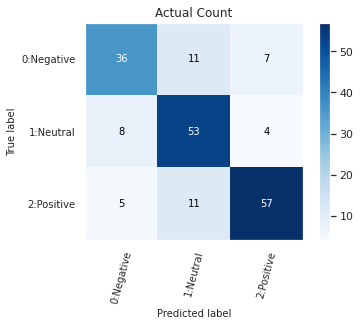

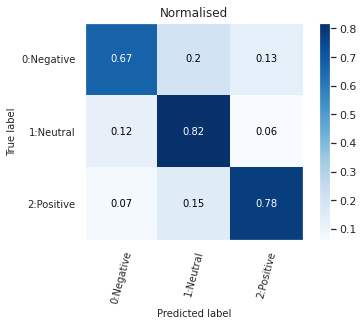

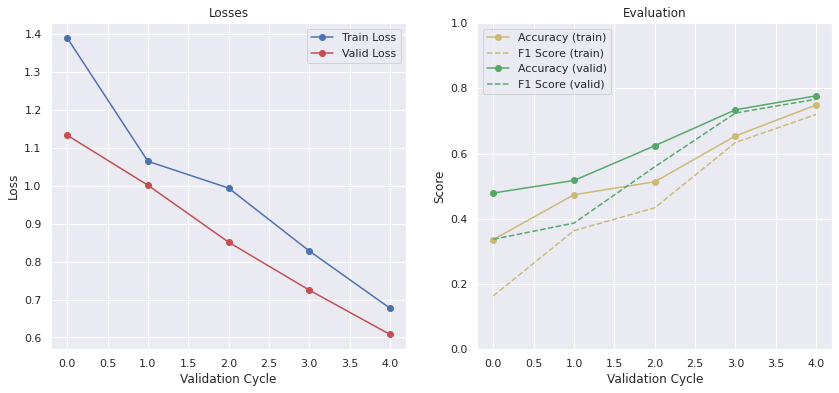

[2020-11-13 00:10:41,439][INFO] ## ================     epoch 2     ===============
[2020-11-13 00:10:42,573][DEBUG] ## Epoch: 2/3, Step: 79, Loss: 9.0889, Acc: 0.7719, F1: 0.7628
[2020-11-13 00:10:45,429][DEBUG] ## Epoch: 2/3, Step: 90, Loss: 8.8084, Acc: 0.7885, F1: 0.7769
[2020-11-13 00:10:48,985][DEBUG] ## Epoch: 2/3, Step: 105, Loss: 8.0352, Acc: 0.8073, F1: 0.7958
[2020-11-13 00:10:52,529][DEBUG] ## Epoch: 2/3, Step: 120, Loss: 7.5358, Acc: 0.8219, F1: 0.8105
[2020-11-13 00:10:56,022][DEBUG] ## Epoch: 2/3, Step: 135, Loss: 7.1876, Acc: 0.8187, F1: 0.8089
[2020-11-13 00:10:59,559][DEBUG] ## Epoch: 2/3, Step: 150, Loss: 7.0278, Acc: 0.8344, F1: 0.8242
[2020-11-13 00:11:00,610][INFO] ## Epoch: 2, Loss: 0.4685, Acc: 0.8344, F1: 0.8242, LR: 7.59e-06


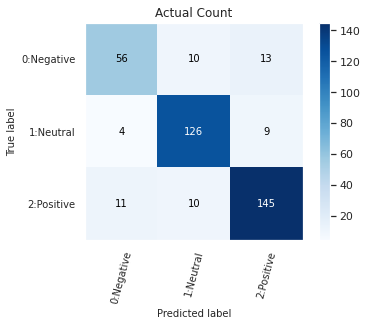

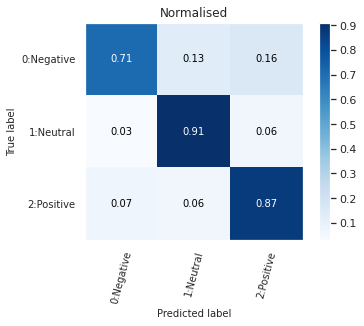

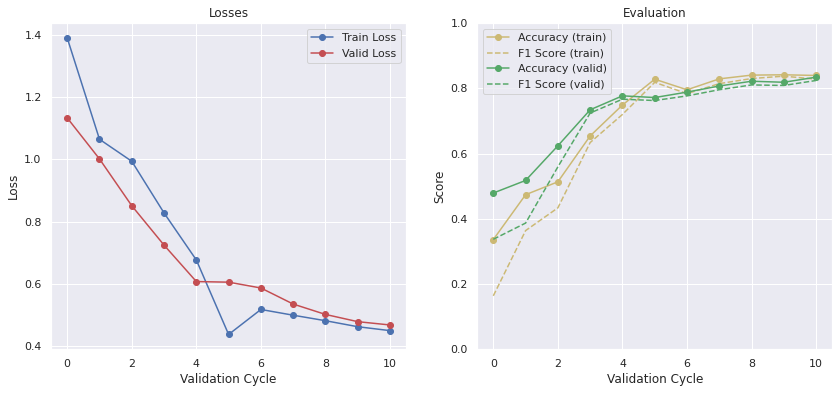

[2020-11-13 00:11:01,470][INFO] ## ================     epoch 3     ===============
[2020-11-13 00:11:03,998][DEBUG] ## Epoch: 3/3, Step: 165, Loss: 7.0061, Acc: 0.8469, F1: 0.8380
[2020-11-13 00:11:07,611][DEBUG] ## Epoch: 3/3, Step: 180, Loss: 7.0439, Acc: 0.8448, F1: 0.8358
[2020-11-13 00:11:11,146][DEBUG] ## Epoch: 3/3, Step: 195, Loss: 6.9676, Acc: 0.8490, F1: 0.8412
[2020-11-13 00:11:14,654][DEBUG] ## Epoch: 3/3, Step: 210, Loss: 6.7363, Acc: 0.8406, F1: 0.8338
[2020-11-13 00:11:18,164][DEBUG] ## Epoch: 3/3, Step: 225, Loss: 6.6802, Acc: 0.8479, F1: 0.8407
[2020-11-13 00:11:19,689][INFO] ## Epoch: 3, Loss: 0.4453, Acc: 0.8479, F1: 0.8407, LR: 2.81e-07


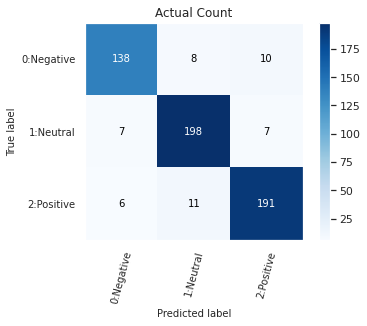

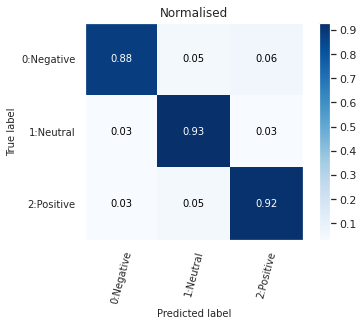

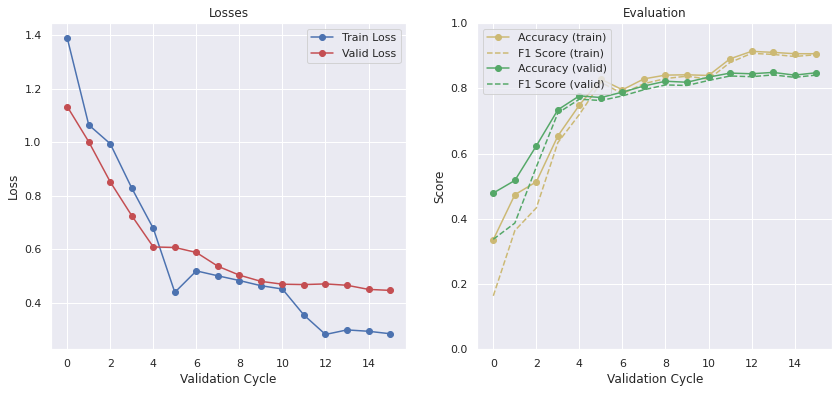


[2020-11-13 00:11:20,882][INFO] ## Process Time (sec): 58.60634465099997

[2020-11-13 00:11:20,884][INFO] ## ############### Start training for 10000 samples ###############


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-11-13 00:11:25,251][INFO] ## Total Training Steps: 471 (157 batches x 3 epochs)


[2020-11-13 00:11:25,411][INFO] ## ================     epoch 1     ===============


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-11-13 00:11:32,764][DEBUG] ## Epoch: 1/3, Step: 31, Loss: 31.8981, Acc: 0.5136, F1: 0.3912
[2020-11-13 00:11:40,027][DEBUG] ## Epoch: 1/3, Step: 62, Loss: 25.7782, Acc: 0.6497, F1: 0.6308
[2020-11-13 00:11:47,268][DEBUG] ## Epoch: 1/3, Step: 93, Loss: 19.1457, Acc: 0.7666, F1: 0.7582
[2020-11-13 00:11:54,619][DEBUG] ## Epoch: 1/3, Step: 124, Loss: 15.8405, Acc: 0.8155, F1: 0.8024
[2020-11-13 00:12:01,902][DEBUG] ## Epoch: 1/3, Step: 155, Loss: 13.7469, Acc: 0.8448, F1: 0.8328
[2020-11-13 00:12:02,080][INFO] ## Epoch: 1, Loss: 0.4434, Acc: 0.8448, F1: 0.8328, LR: 1.49e-05


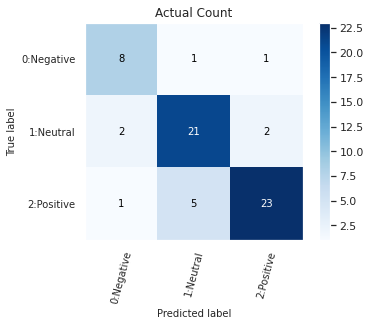

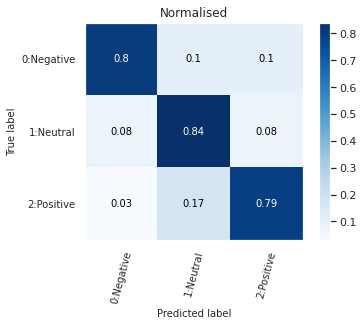

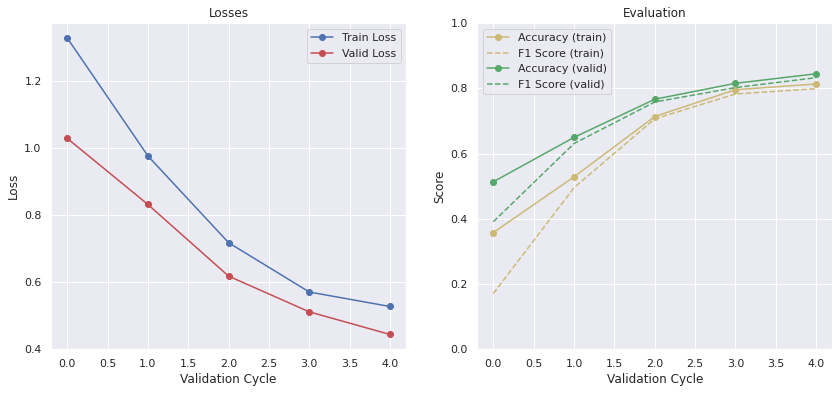

[2020-11-13 00:12:02,924][INFO] ## ================     epoch 2     ===============
[2020-11-13 00:12:05,068][DEBUG] ## Epoch: 2/3, Step: 157, Loss: 13.8437, Acc: 0.8427, F1: 0.8301
[2020-11-13 00:12:12,026][DEBUG] ## Epoch: 2/3, Step: 186, Loss: 14.1824, Acc: 0.8533, F1: 0.8403
[2020-11-13 00:12:19,318][DEBUG] ## Epoch: 2/3, Step: 217, Loss: 12.8882, Acc: 0.8609, F1: 0.8505
[2020-11-13 00:12:26,756][DEBUG] ## Epoch: 2/3, Step: 248, Loss: 12.6150, Acc: 0.8649, F1: 0.8540
[2020-11-13 00:12:34,025][DEBUG] ## Epoch: 2/3, Step: 279, Loss: 11.9370, Acc: 0.8684, F1: 0.8586
[2020-11-13 00:12:41,385][DEBUG] ## Epoch: 2/3, Step: 310, Loss: 11.7730, Acc: 0.8720, F1: 0.8625
[2020-11-13 00:12:41,731][INFO] ## Epoch: 2, Loss: 0.3798, Acc: 0.8720, F1: 0.8625, LR: 7.50e-06


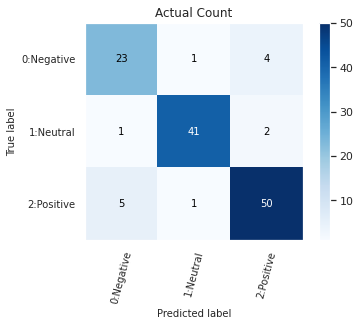

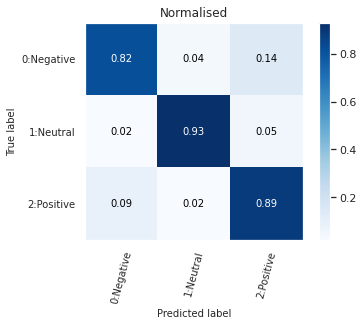

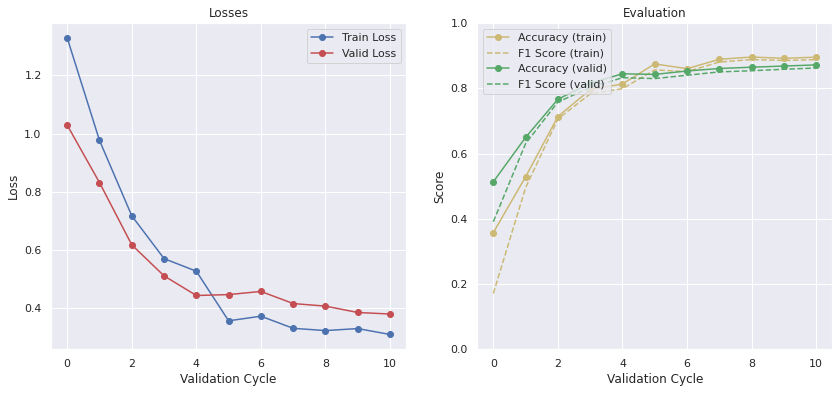

[2020-11-13 00:12:42,543][INFO] ## ================     epoch 3     ===============
[2020-11-13 00:12:49,540][DEBUG] ## Epoch: 3/3, Step: 341, Loss: 12.3657, Acc: 0.8745, F1: 0.8654
[2020-11-13 00:12:56,832][DEBUG] ## Epoch: 3/3, Step: 372, Loss: 12.6284, Acc: 0.8710, F1: 0.8622
[2020-11-13 00:13:04,344][DEBUG] ## Epoch: 3/3, Step: 403, Loss: 11.9056, Acc: 0.8795, F1: 0.8700
[2020-11-13 00:13:11,809][DEBUG] ## Epoch: 3/3, Step: 434, Loss: 12.3246, Acc: 0.8775, F1: 0.8684
[2020-11-13 00:13:19,224][DEBUG] ## Epoch: 3/3, Step: 465, Loss: 12.1938, Acc: 0.8800, F1: 0.8711
[2020-11-13 00:13:19,748][INFO] ## Epoch: 3, Loss: 0.3933, Acc: 0.8800, F1: 0.8711, LR: 1.42e-07


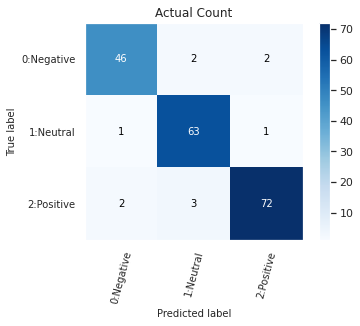

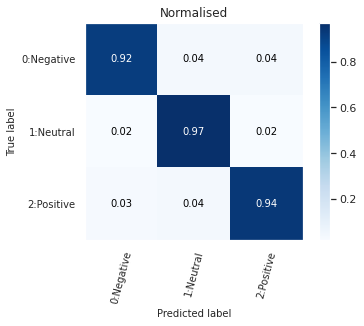

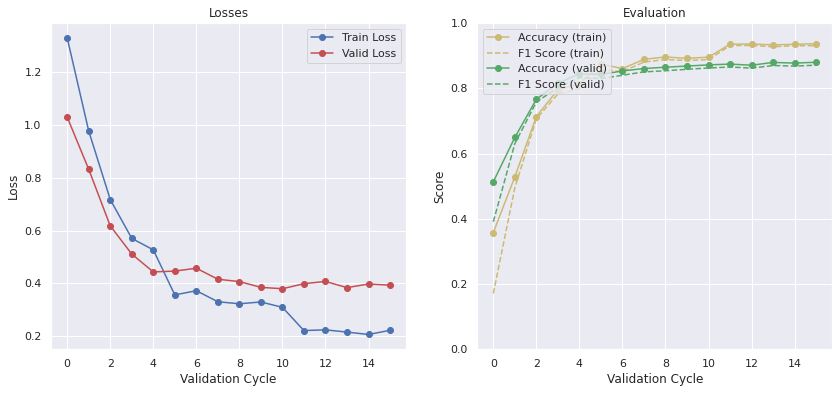


[2020-11-13 00:13:20,596][INFO] ## Process Time (sec): 115.34589016599989

[2020-11-13 00:13:20,598][INFO] ## ############### Start training for 50000 samples ###############


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

[2020-11-13 00:13:25,115][INFO] ## Total Training Steps: 2346 (782 batches x 3 epochs)


[2020-11-13 00:13:25,280][INFO] ## ================     epoch 1     ===============


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[2020-11-13 00:14:02,622][DEBUG] ## Epoch: 1/3, Step: 156, Loss: 96.4209, Acc: 0.7645, F1: 0.7537
[2020-11-13 00:14:39,629][DEBUG] ## Epoch: 1/3, Step: 312, Loss: 58.0833, Acc: 0.8800, F1: 0.8699
[2020-11-13 00:15:16,636][DEBUG] ## Epoch: 1/3, Step: 468, Loss: 46.1878, Acc: 0.9054, F1: 0.8979
[2020-11-13 00:15:53,979][DEBUG] ## Epoch: 1/3, Step: 624, Loss: 41.9018, Acc: 0.9134, F1: 0.9075
[2020-11-13 00:16:31,000][DEBUG] ## Epoch: 1/3, Step: 780, Loss: 42.8527, Acc: 0.9110, F1: 0.9028
[2020-11-13 00:16:31,177][INFO] ## Epoch: 1, Loss: 0.2747, Acc: 0.9110, F1: 0.9028, LR: 1.48e-05


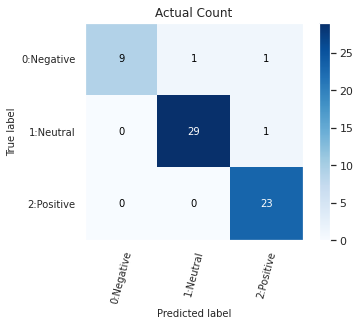

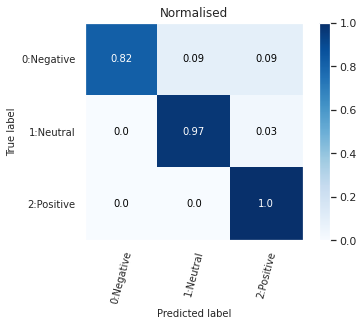

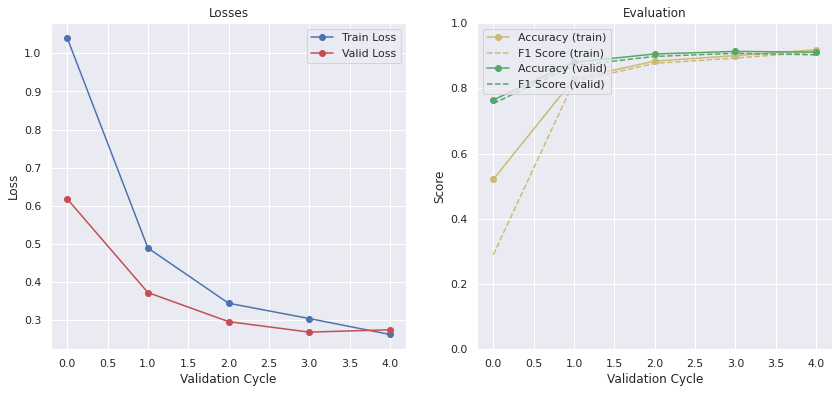

[2020-11-13 00:16:32,030][INFO] ## ================     epoch 2     ===============
[2020-11-13 00:16:42,080][DEBUG] ## Epoch: 2/3, Step: 782, Loss: 40.8123, Acc: 0.9146, F1: 0.9071
[2020-11-13 00:17:18,476][DEBUG] ## Epoch: 2/3, Step: 936, Loss: 36.5303, Acc: 0.9292, F1: 0.9249
[2020-11-13 00:17:55,487][DEBUG] ## Epoch: 2/3, Step: 1092, Loss: 34.6345, Acc: 0.9294, F1: 0.9248
[2020-11-13 00:18:32,615][DEBUG] ## Epoch: 2/3, Step: 1248, Loss: 34.0678, Acc: 0.9345, F1: 0.9305
[2020-11-13 00:19:09,631][DEBUG] ## Epoch: 2/3, Step: 1404, Loss: 32.6882, Acc: 0.9380, F1: 0.9345
[2020-11-13 00:19:46,729][DEBUG] ## Epoch: 2/3, Step: 1560, Loss: 30.9043, Acc: 0.9365, F1: 0.9325
[2020-11-13 00:19:47,079][INFO] ## Epoch: 2, Loss: 0.1981, Acc: 0.9365, F1: 0.9325, LR: 7.43e-06


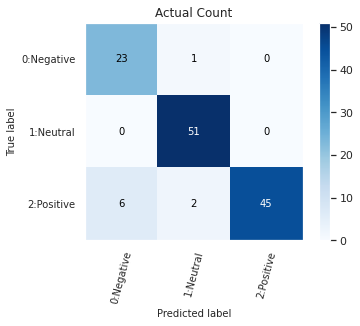

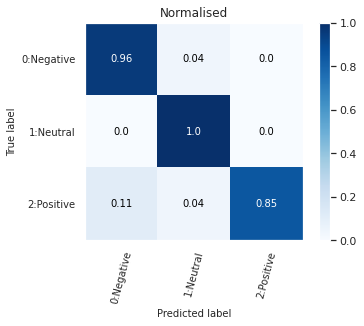

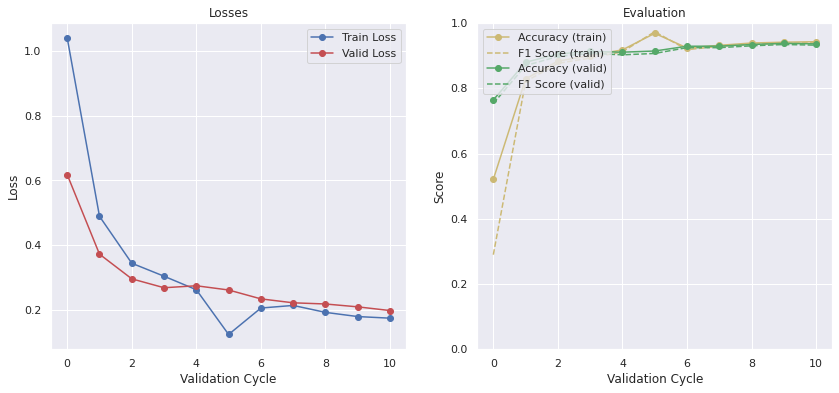

[2020-11-13 00:19:47,889][INFO] ## ================     epoch 3     ===============
[2020-11-13 00:20:24,513][DEBUG] ## Epoch: 3/3, Step: 1716, Loss: 32.2640, Acc: 0.9355, F1: 0.9319
[2020-11-13 00:21:01,244][DEBUG] ## Epoch: 3/3, Step: 1872, Loss: 32.7526, Acc: 0.9357, F1: 0.9317
[2020-11-13 00:21:38,012][DEBUG] ## Epoch: 3/3, Step: 2028, Loss: 32.2109, Acc: 0.9347, F1: 0.9310
[2020-11-13 00:22:14,583][DEBUG] ## Epoch: 3/3, Step: 2184, Loss: 32.9143, Acc: 0.9373, F1: 0.9334
[2020-11-13 00:22:51,303][DEBUG] ## Epoch: 3/3, Step: 2340, Loss: 32.3679, Acc: 0.9368, F1: 0.9331
[2020-11-13 00:22:51,818][INFO] ## Epoch: 3, Loss: 0.2075, Acc: 0.9368, F1: 0.9331, LR: 2.84e-08


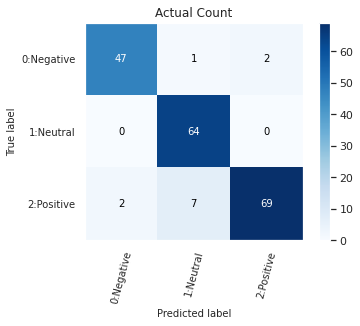

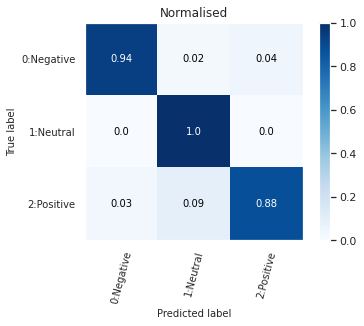

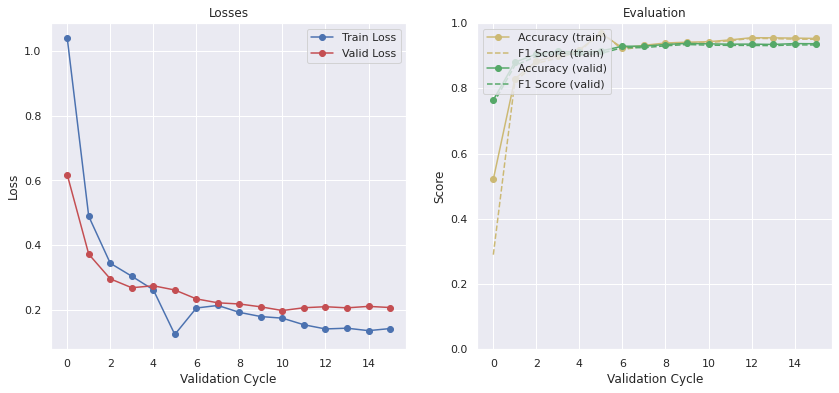


[2020-11-13 00:22:52,656][INFO] ## Process Time (sec): 567.5405327589999


,Accuracy,F1(macro),Total_Time,ms/text
1000,0.5417,0.4825,28.3888,28.3888
5000,0.8479,0.8407,58.6063,11.7213
10000,0.88,0.8711,115.346,11.5346
50000,0.9368,0.9331,567.541,11.3508


In [ ]:
# Define the training parameters
num_samples = [1000, 5000, 10000, 50000]
epochs=3
patience=3
batch_size=64
seq_len = 30
lr=2e-5
clip=1.0
log_level=logging.DEBUG

# Run!
result_bert, model_trained_bert = train_cycles(train_df['text'], train_df['label'], vocab, num_samples, 'BERT', epochs, patience, batch_size, seq_len, lr, clip, log_level)
result_bert

# BERT model metrics comparison
## reconstruct accuracy,F1,training time results based on above training results when the notebook get disconnected 

In [4]:
#reconstruct the bert result dataframe. If the notebook didn't get disconnected, don't need to run this cell. 
# If you decide to use this cell, make sure to check the metric scores match the training result.
n_trains = [1000, 5000, 10000, 50000]
result_bert = pd.DataFrame(columns=['Accuracy', 'F1(macro)', 'Total_Time'], index=n_trains)
result_bert.loc[1000] = (0.5417,0.4825,28.3888)
result_bert.loc[5000] = (0.8479,0.8407,58.6063)
result_bert.loc[10000] = (0.88,0.8711,115.346)
result_bert.loc[50000] = (0.9368,0.9331,567.541)
result_bert['ms/data'] = result_bert['Total_Time'] / result_bert.index * 1000
result_bert


,Accuracy,F1(macro),Total_Time,ms/data
1000,0.5417,0.4825,28.3888,28.3888
5000,0.8479,0.8407,58.6063,11.7213
10000,0.88,0.8711,115.346,11.5346
50000,0.9368,0.9331,567.541,11.3508


# Plot results
Accuray, F1, Total training time and time per sample

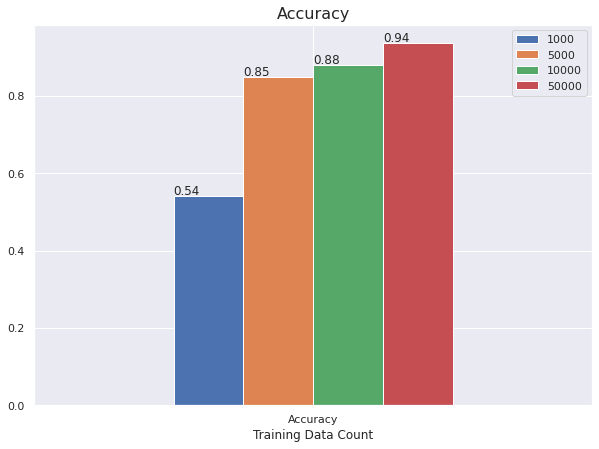

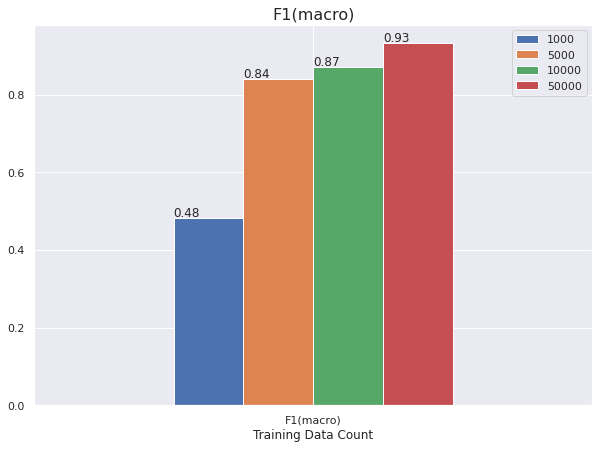

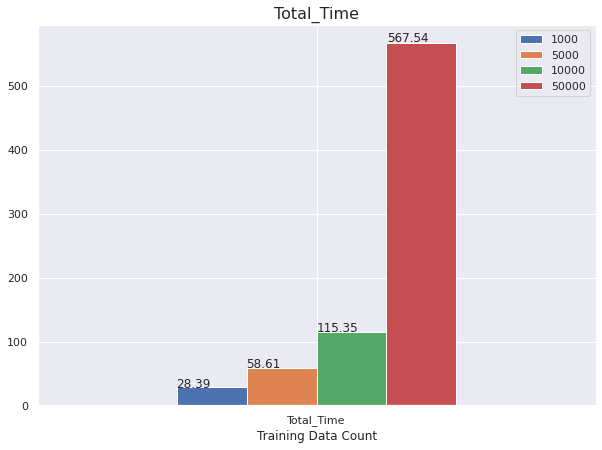

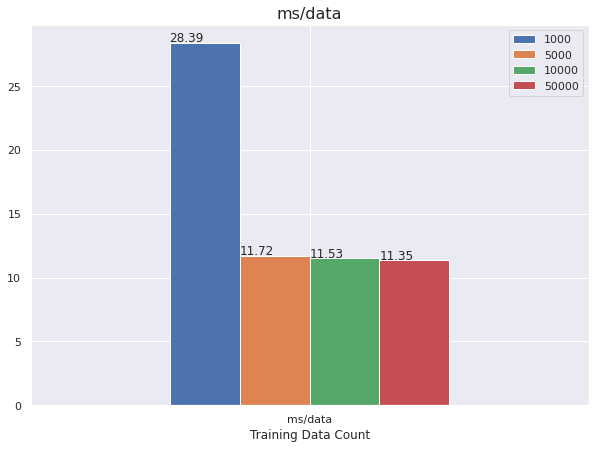

In [12]:
def plot_result(column):
    result_accuracy = pd.DataFrame(data=result_bert[column]).T
    ax = result_accuracy.plot.bar(rot=0, figsize=(10,7))
    ax.set_title(column, fontsize=16)
    ax.set_xlabel('Training Data Count')
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

plot_result('Accuracy')
plot_result('F1(macro)')
plot_result('Total_Time')
plot_result('ms/data')